# Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

from astropy.io import fits
from scipy.ndimage import median_filter
from scipy.signal import correlate, find_peaks
from numpy.polynomial.polynomial import Polynomial
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift as nd_shift 
from scipy.signal import savgol_filter

# Image Functions

In [211]:
def load_fits_2d(path: str) -> np.ndarray:
    with fits.open(path) as hdul:
        data = hdul[0].data
    data = np.squeeze(data).astype(np.float32)
    if data.ndim != 2:
        raise ValueError(f"{path}: erwartet 2D, bekam shape {data.shape}")
    return data

def moving_average(x_sample, delta):
    N_elements_to_check = 2*delta+1
    length = len(x_sample)
    x_average = x_sample.copy()
    
    #Normale Werte
    for n in range(delta, length-delta):
        x_average[n] = sum(x_sample[n-delta:n+delta])/N_elements_to_check

    #Randwerte
    for n in range(delta):
        #Anfang
        x_average[n] = sum(x_sample[:n+delta])/(n+delta)
        #Ende
        x_average[length-delta + n] = sum(x_sample[length - delta -n:length])/(delta+n)

    return x_average

def extract_1d_spectrum(data2d: np.ndarray, half_height: int = 20, bg_offset: int = 50, bg_half: int = 10, filtering: bool = False, normalize: bool = False, delta = 10):
    """
    - findet y0 über Summe entlang x (Spurmaximum)
    - extrahiert Summe im Fenster [y0-half_height, y0+half_height]
    - zieht Hintergrund ab (aus zwei Off-Trace Fenstern)
    """
    ny, nx = data2d.shape

    # Spurposition schätzen
    y_profile = np.sum(data2d, axis=1)
    y0 = int(np.argmax(y_profile))

    y1 = max(0, y0 - half_height)
    y2 = min(ny, y0 + half_height + 1)

    # Hintergrundfenster ober-/unterhalb
    yb1a = ny - bg_offset - bg_half # lower Window beginning
    yb1b = ny - bg_offset + bg_half + 1 # lower Window end
    yb2a = y0 + bg_offset - bg_half # upper Window beginning
    yb2b = y0 + bg_offset + bg_half + 1 # upper Window end

    # TODO: Datenanalyse von schwarzem Hintergrund einbauen berechne Fehler

    # yb1a = max(0, y0 - bg_offset - bg_half) # lower Window beginning
    # yb1b = max(0, y0 - bg_offset + bg_half + 1) # lower Window end
    # yb2a = min(ny, y0 + bg_offset - bg_half) # upper Window beginning
    # yb2b = min(ny, y0 + bg_offset + bg_half + 1) # upper Window end


    bg_rows = []
    if yb1b > yb1a:
        bg_rows.append(data2d[yb1a:yb1b, :])
    if yb2b > yb2a:
        bg_rows.append(data2d[yb2a:yb2b, :])

    if len(bg_rows) > 0:
        bg = np.median(np.vstack(bg_rows), axis=0)  # 1D background vs x
    else:
        bg = np.zeros(nx, dtype=np.float32)

    spec = np.sum(data2d[y1:y2, :], axis=0) - (y2 - y1) * bg

    if filtering == True:
        spec = moving_average(spec, delta)
        # spec = savgol_filter(spec, window_length= 31, polyorder=3)


    if normalize:

        # NaNs vermeiden
        spec = spec/np.sum(spec)



    xpix = np.arange(nx, dtype=np.float32)
    return xpix, spec, y0, (y1, y2)





def stitch_spectra(specA: np.ndarray, specB: np.ndarray, shift: int):
    """
    Erzeugt combined Spectrum auf gemeinsamer Pixelachse:
    - A liegt auf x=[0..lenA-1]
    - B liegt auf x=[shift..shift+lenB-1]
    In Überlapp: Mittelwert.
    """
    lenA = len(specA)
    lenB = len(specB)

    if shift < 0:
        x1 = lenA + shift + lenB

        

        x = np.arange(0, x1)
        print(len(x))

        comb = np.zeros_like(x, dtype=np.float64)       
        comb[0:lenA] = specA
        comb[lenA:] = specB[np.abs(shift):]
    else:
        x1 = lenA - shift + lenB

        print(x1)
        x = np.arange(0, x1)

        comb = np.zeros_like(x, dtype=np.float64)

        comb[0:lenA-shift] = specA[:lenA-shift]
        comb[lenA-shift:] = specB
 

    return x.astype(np.float32), comb.astype(np.float32)




## Plot Image

In [157]:
def plot_spectrum(x_comb, lam_axis, s_comb, title,
                  zoom1=(5500, 6000), zoom2 = (6000, 6500), zoom3 = (6500, 7000), ):
    # -------- Figure 1: Pixel + Wavelength --------
    fig1, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

    ax[0].plot(x_comb, s_comb, lw=1)
    ax[0].set_title(title)
    ax[0].set_ylabel(r"Flux [W/m$^2$]")
    ax[0].set_xlabel("Pixel")
    ax[0].grid(True, alpha=0.3)

    ax[1].plot(lam_axis, s_comb, lw=1)
    ax[1].set_ylabel(r"Flux [W/m$^2$]")
    ax[1].set_xlabel("Wavelength [Angstrom]")
    ax[1].grid(True, alpha=0.3)

    fig1.tight_layout()

    # -------- Figure 2: 2x2 with constraints/zooms --------
    fig2, ax2 = plt.subplots(2, 2, figsize=(12, 10), sharex=False, sharey=False)

    # (0,0) full spectrum
    ax2[0, 0].plot(lam_axis, s_comb, lw=1)
    ax2[0, 0].set_title(f"{title} (full)")
    ax2[0, 0].set_xlabel("Wavelength [Angstrom]")
    ax2[0, 0].set_ylabel("Flux")
    ax2[0, 0].grid(True, alpha=0.3)

    # (0,1) zoom1
    ax2[0, 1].plot(lam_axis, s_comb, lw=1)
    ax2[0, 1].set_xlim(*zoom1)
    ax2[0, 1].set_title(f"{title} ({zoom1[0]}–{zoom1[1]} Å)")
    ax2[0, 1].set_xlabel("Wavelength [Angstrom]")
    ax2[0, 1].set_ylabel("Flux")
    ax2[0, 1].grid(True, alpha=0.3)

    # (1,0) full spectrum again (or remove if you don't want duplication)
    ax2[1, 0].plot(lam_axis, s_comb, lw=1)
    ax2[1, 0].set_xlim(*zoom2)
    ax2[1, 0].set_title(f"{title} ({zoom2[0]}–{zoom2[1]} Å)")
    ax2[1, 0].set_xlabel("Wavelength [Angstrom]")
    ax2[1, 0].set_ylabel("Flux")
    ax2[1, 0].grid(True, alpha=0.3)

    # (1,1) zoom2
    ax2[1, 1].plot(lam_axis, s_comb, lw=1)
    ax2[1, 1].set_xlim(*zoom3)
    ax2[1, 1].set_title(f"{title} ({zoom3[0]}–{zoom3[1]} Å)")
    ax2[1, 1].set_xlabel("Wavelength [Angstrom]")
    ax2[1, 1].set_ylabel("Flux")
    ax2[1, 1].grid(True, alpha=0.3)

    fig2.tight_layout()

    plt.show()    

Filename: Astrowoche2025/1_night/Kal_1/Capella_1/capella_spec_1.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      40   (1530, 1020)   int16 (rescales to uint16)   
Filename: Astrowoche2025/3_night/Kal_2/Regulus_1/regulus_spec_1.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      40   (1530, 1020)   int16 (rescales to uint16)   


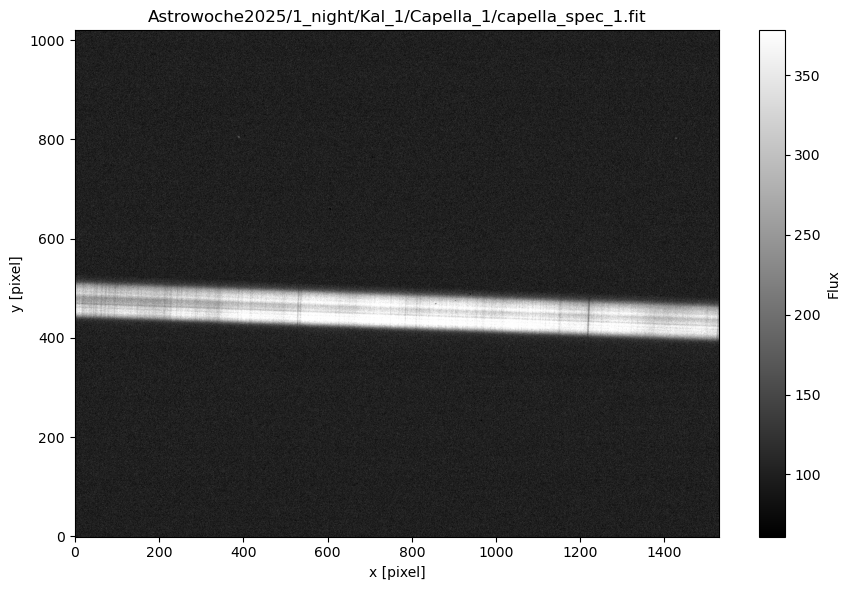

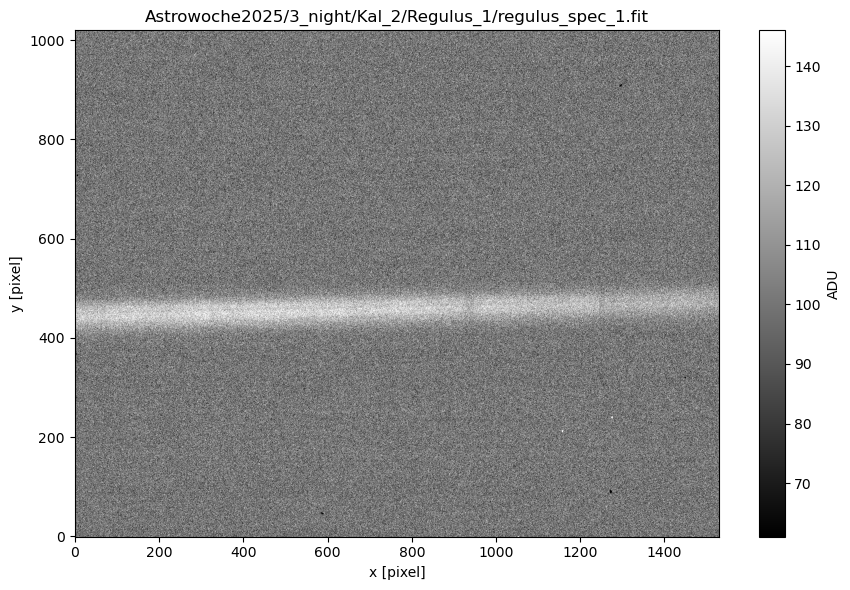

In [90]:
path1 = "Astrowoche2025/1_night/Kal_1/Capella_1/capella_spec_1.fit"
# path1 = "Astrowoche2025/3_night/Kal_1/kal_1_0_35/kal_1_0_35_after.fit"

with fits.open(path1) as hdul:
    hdul.info()                   # zeigt genau das, was du gepostet hast
    data1 = hdul[0].data.astype(np.float32)   # wichtig: in float umwandeln
    header = hdul[0].header

path2 = "Astrowoche2025/3_night/Kal_2/Regulus_1/regulus_spec_1.fit"
# path2 = "Astrowoche2025/1_night/Kal_1/kal_1_after.fit"
# path2 = "Astrowoche2025/3_night/Kal_1/kal_1_1_25/1_25/kal_1_1_25.fit"
# path2 = "Astrowoche2025/1_night/Kal_2/kal_0_35/kal_0_35_after.FIT"


with fits.open(path2) as hdul:
    hdul.info()                   # zeigt genau das, was du gepostet hast
    data2 = hdul[0].data.astype(np.float32)   # wichtig: in float umwandeln
    header = hdul[0].header
vmin, vmax = np.percentile(data1, [1, 99])

# Image 1
plt.figure(figsize=(9,6))
plt.imshow(data1, origin="lower", cmap="gray", vmin=vmin, vmax=vmax, aspect="auto")
plt.colorbar(label="Flux")
plt.title(path1)
plt.xlabel("x [pixel]")
plt.ylabel("y [pixel]")
plt.tight_layout()
plt.show()

vmin, vmax = np.percentile(data2, [1, 99])
#Image 2
plt.figure(figsize=(9,6))
plt.imshow(data2, origin="lower", cmap="gray", vmin=vmin, vmax=vmax, aspect="auto")
plt.colorbar(label="ADU")
plt.title(path2)
plt.xlabel("x [pixel]")
plt.ylabel("y [pixel]")
plt.tight_layout()
plt.show()

y0: 448
y1: 343


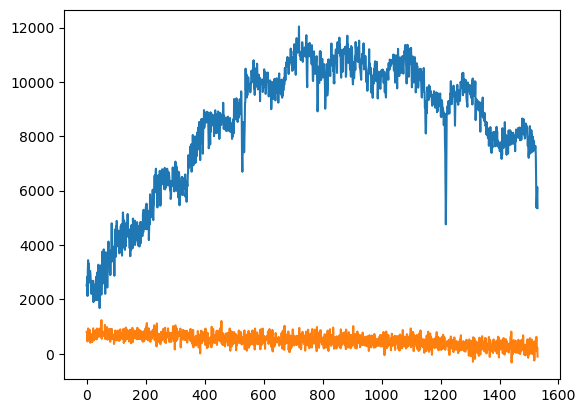

In [5]:
x1, s1, y0, *rest = extract_1d_spectrum(data1, filtering = False, normalize = False)
x2, s2, y1, *rest = extract_1d_spectrum(data2, filtering = False, normalize = False)


print("y0:", y0)
print("y1:", y1)
plt.plot(x1,s1)
plt.plot(x2,s2)
plt.show()

## Estimate Shift

## Shift determination

In [184]:


def determine_shift(specA, specB, guess=None):
    """This function determines the shift of the spectrum B relative to A.

    Returns:
        shift: estimated shift of spectrum
    """
    # Normalize spectra for better correlation
    specA_norm = (specA - np.mean(specA)) / np.std(specA)
    specB_norm = (specB - np.mean(specB)) / np.std(specB)
    

    
    # Find peak in correlation
    if (guess is not None) and (guess <= len(specA)//2): #if the shift is no too large we can work with the mode 'same'
        #Compute CC
        correlation = correlate(specA_norm, specB_norm, mode='same')
        lag = np.arange(-len(specA)//2 + 1, len(specA)//2 + 1)
        
        # Constrain search around guess
        guess_idx = np.argmin(np.abs(lag - guess))
        search_range = 100
        start = max(0, guess_idx - search_range)
        end = min(len(lag), guess_idx + search_range)
        peak_idx = start + np.argmax(correlation[start:end])

    elif (guess is not None) and (guess > len(specA)//2): #if guessed shift is large, then we have to work with the mode 'full' and a larger lag
        #Compute Cross-Correlation
        correlation = correlate(specA_norm, specB_norm, mode='full')
        lag = np.arange(-len(specA) + 1, len(specA) + 1)
        guess_idx = np.argmin(np.abs(lag - guess))
        search_range = 100
        start = max(0, guess_idx - search_range)
        end = min(len(lag), guess_idx + search_range)
        peak_idx = start + np.argmax(correlation[start:end])
    else:
        peak_idx = np.argmax(correlation)
    
    return lag[peak_idx]

690


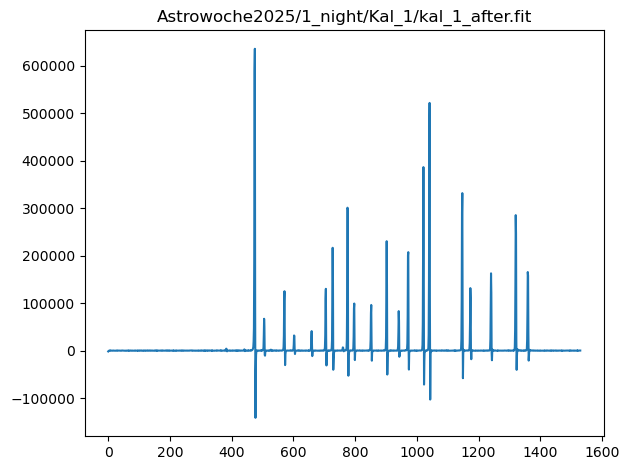

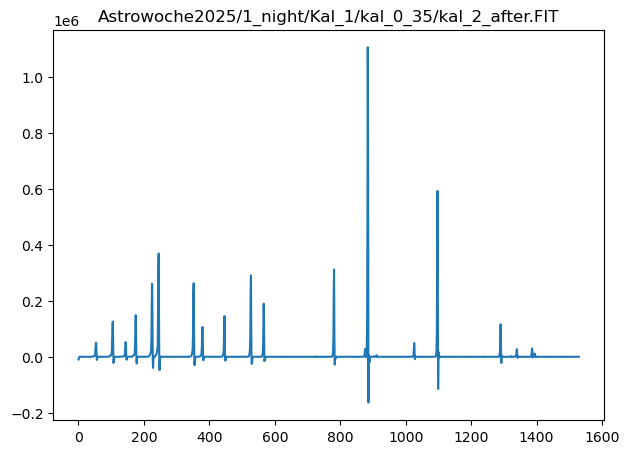

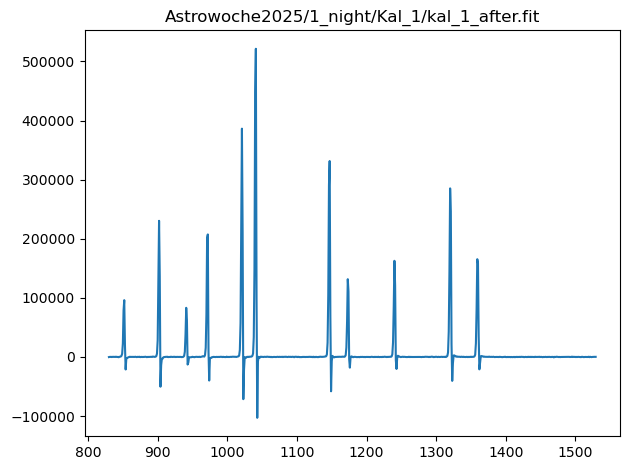

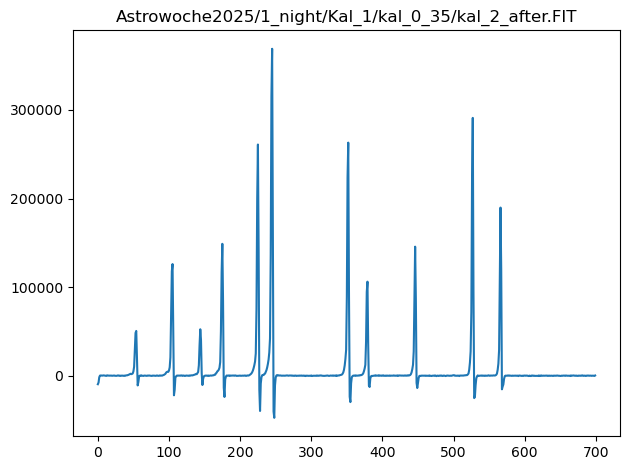

2370


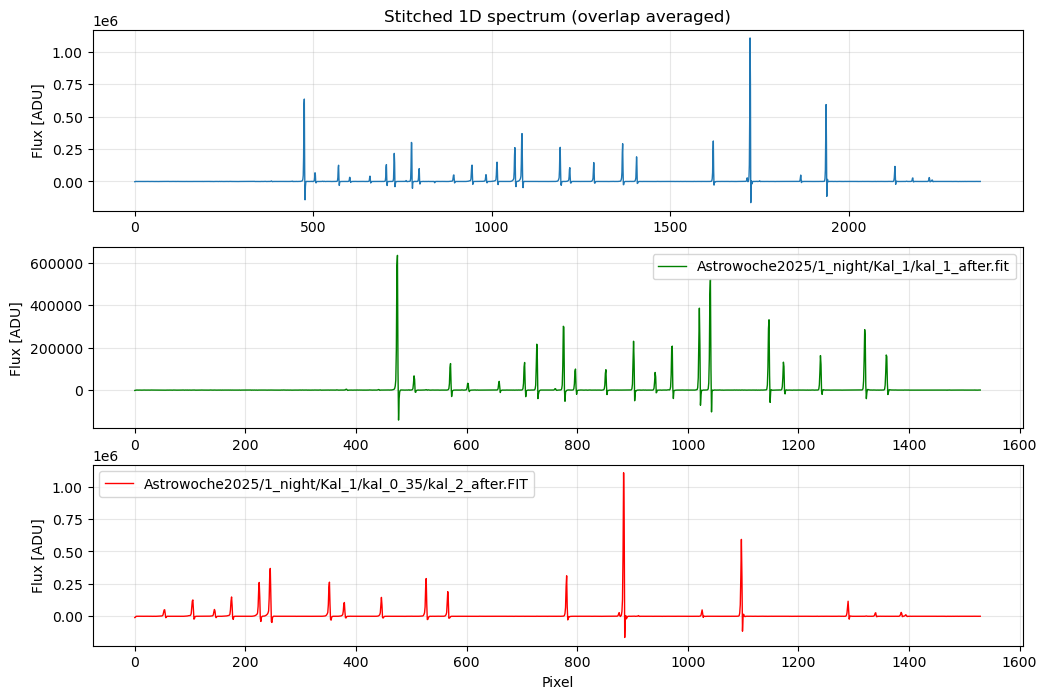

In [146]:
path1 = "Astrowoche2025/1_night/Kal_1/kal_1_after.fit"
path2 = "Astrowoche2025/1_night/Kal_1/kal_0_35/kal_2_after.FIT"


guess = 700
data1 = load_fits_2d(path1)
data2 = load_fits_2d(path2)

x1,s1, *rest = extract_1d_spectrum(data1)
x2,s2, *rest = extract_1d_spectrum(data2)

# shift, score = determine_shift(specA=s1, specB = s2, guess =800, window = 200, edge = "center")
shift= determine_shift(s1, s2, guess=850)
# shift, score = determine_shift(s1, s2, guess=800, search=150, window=640, edge="end")
print(shift)

plt.plot(x1,s1)
plt.title(path1)
plt.tight_layout()
plt.show()

plt.plot(x2,s2)
plt.title(path2)
plt.tight_layout()
plt.show()


plt.plot(x1[-guess:],s1[-guess:])
plt.title(path1)
plt.tight_layout()
plt.show()

plt.plot(x2[:guess],s2[:guess])
plt.title(path2)
plt.tight_layout()
plt.show()



x_comb, s_comb = stitch_spectra(s1,s2, shift = int(shift))


fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=False)

# --- 1: Gestitchtes Spektrum ---
axes[0].plot(x_comb, s_comb, lw=1)
# axes[0].plot(x_comb[mOnlyA], s_comb[mOnlyA], lw=1, label="A only")
# axes[0].plot(x_comb[mOnlyB], s_comb[mOnlyB], lw=1, label="B only")
# axes[0].plot(x_comb[mOverlap], s_comb[mOverlap], lw=1, label="overlap")
axes[0].set_title("Stitched 1D spectrum (overlap averaged)")
axes[0].set_ylabel("Flux [ADU]")
axes[0].grid(True, alpha=0.3)

# --- 2: kal_2_25 ---
axes[1].plot(x1, s1, lw=1, color='g', label=path1)
axes[1].legend()
axes[1].set_ylabel("Flux [ADU]")
axes[1].grid(True, alpha=0.3)

# --- 3: kal_0_35 ---
axes[2].plot(x2, s2, lw=1, color='r', label=path2)
axes[2].legend()
axes[2].set_xlabel("Pixel")
axes[2].set_ylabel("Flux [ADU]")
axes[2].grid(True, alpha=0.3)



In [176]:
def multiple_files(folder_path, filtering = False, normalize= False, delta = 10):
    
    spec_all  = []


    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        img = fits.getdata(file_path)
        pixel, spec, *rest = extract_1d_spectrum(img, filtering = filtering, normalize= normalize, delta = delta)
        print(file_path)
        spec_all.append(spec)
        print(len(spec))
    
    spectra = np.array(spec_all)
    pixel = np.arange(spectra.shape[1])

    avg_spectra = np.median(spectra, axis = 0)
    return pixel, avg_spectra

def combine_spec(path1, path2, folder1 : bool = False, folder2 : bool = False, plot: bool= True, shift = None, scal = None, filtering: bool = False, normalize: bool = False, delta = 10, guess = None):
    """Finds shift of image 1 in image 2 and combines the two spectras by the correpsonding shift. 

    Args:
        path1 (fits file): data of grating setting 1_25
        path2 (fits file): data of grating setting 0_35
        folder1: if path1 corresponds to a folder
        folder2: if path2 corresponds to a folder
        plot: if True, then plot will be displayed
        shift: if None, phase_cross_correlation will determine shift
        scal: if not none, then the spectrum will be made more continuous
        filtering: if True, extract_1d_spectrum will filter data

    Returns:
        x_comb: combined x axis
        s_comb: combined spectrum
        x1, s1: x and spectrum of grating setting 1_25
        x2, s2: x and spectrum of grating setting 0_35
        shift: determined shift between both images
    """
    # load FITS 


    if (folder1 == 1) & (folder2 == 1):
        x1, s1 = multiple_files(path1, filtering = filtering, normalize= normalize, delta = delta) 
        x2, s2 = multiple_files(path2, filtering = filtering,normalize= normalize, delta = delta) 
    elif (folder1 == 1) & (folder2 != 0):
        x1, s1 = multiple_files(path1, filtering = filtering, normalize= normalize, delta = delta)
        img2 = fits.getdata(path2)

        x2, s2, *rest = extract_1d_spectrum(img2, half_height=10, filtering=filtering, normalize= normalize, delta = delta)
    elif (folder2 ==1): 
        img1 = fits.getdata(path1)
        x1, s1, *rest =  extract_1d_spectrum(img1, half_height=10, filtering=filtering, normalize= normalize, delta = delta)
        x2, s2 = multiple_files(path2, filtering, normalize= normalize, delta = delta)
    else:
        img1 = fits.getdata(path1)
        img2 = fits.getdata(path2)
        x1, s1, *rest =  extract_1d_spectrum(img1, half_height=10, filtering = filtering, normalize= normalize, delta = delta)
        x2, s2, *rest = extract_1d_spectrum(img2, half_height=10, filtering = filtering, normalize= normalize, delta = delta)


    if shift is None:
        shift = determine_shift(s1, s2, guess)
        print("shift:", shift)  # bei 1D: ein Array mit einem Wert

    
    if scal is not None: 
        _shift = abs(shift)    
        scal = s1[-_shift]/s2[0] #determine "factor" between the last point of s1 and first point of s2.
        s2 *= scal #make spectrum more continuous
 
    x_comb, s_comb = stitch_spectra(s1, s2, shift= int(shift)) # erster eintrag muss grating 0_35 sein zweiter 1_25



    if plot == True: 
        # mOnlyA = mA & ~mB
        # mOnlyB = mB & ~mA
        # mOverlap = mA & mB
        fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=False)

        # --- 1: Gestitchtes Spektrum ---
        axes[0].plot(x_comb, s_comb, lw=1)
        # axes[0].plot(x_comb[mOnlyA], s_comb[mOnlyA], lw=1, label="A only")
        # axes[0].plot(x_comb[mOnlyB], s_comb[mOnlyB], lw=1, label="B only")
        # axes[0].plot(x_comb[mOverlap], s_comb[mOverlap], lw=1, label="overlap")
        axes[0].set_title("Stitched 1D spectrum (overlap averaged)")
        axes[0].set_ylabel("Flux [ADU]")
        axes[0].grid(True, alpha=0.3)

        # --- 2: kal_2_25 ---
        axes[1].plot(x1, s1, lw=1, color='g', label=path1)
        axes[1].legend()
        axes[1].set_ylabel("Flux [ADU]")
        axes[1].grid(True, alpha=0.3)

        # --- 3: kal_0_35 ---
        axes[2].plot(x2, s2, lw=1, color='r', label=path2)
        axes[2].legend()
        axes[2].set_xlabel("Pixel")
        axes[2].set_ylabel("Flux [ADU]")
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


    return x_comb, s_comb, shift, x1, s1, x2, s2, scal

  
    

# Wavelength calibration

In [91]:
def fit_from_two_points(x1, x2, l1, l2):
    a1 = (l2 - l1) / (x2 - x1)
    a0 = l1 - a1 * x1
    return np.array([a1, a0])  # np.polyval erwartet [a1, a0] für deg=1

def count_inliers(coeff, x_peaks, lam_ref, tol=1.0):
    lam_pred = np.polyval(coeff, x_peaks)
    # Abstand jedes Predicted zu nächster Referenzlinie
    dist = np.array([np.min(np.abs(lam_ref - lp)) for lp in lam_pred])
    return np.sum(dist < tol), dist

def calibrate_with_anchor(x_comb, s_comb, ref_w, height=5000, lam0=5850.0,
                          N=15, tol=1.0):
    peaks, _ = find_peaks(s_comb, height=height)
    x_peaks = np.sort(x_comb[peaks])

    # Anker: linksester Peak ~ 5800Å
    x0 = x_peaks[0]
    j0 = int(np.argmin(np.abs(ref_w - lam0)))
    l0 = ref_w[j0]

    # Kandidaten: nächste Peaks
    x_obs = x_peaks[:min(len(x_peaks), N)]

    # Kandidaten-Referenz: Bereich rechts vom Anker
    lam_ref_win = ref_w[(ref_w >= l0 - 50) & (ref_w <= l0 + 800)]

    best = None  # (ninliers, coeff)
    # Wir fixen den ersten Punkt (x0->l0) und wählen einen zweiten Punkt
    for xi in x_obs[1:]:
        # zweite Referenzlinie durchprobieren (nicht zu nah an l0)
        for l2 in lam_ref_win:
            if abs(l2 - l0) < 20:
                continue
            if abs(xi - x0) < 10:
                continue

            coeff = fit_from_two_points(x0, xi, l0, l2)
            ninl, _ = count_inliers(coeff, x_peaks, ref_w, tol=tol)

            if best is None or ninl > best[0]:
                best = (ninl, coeff)

    return best  # ninliers, coeff


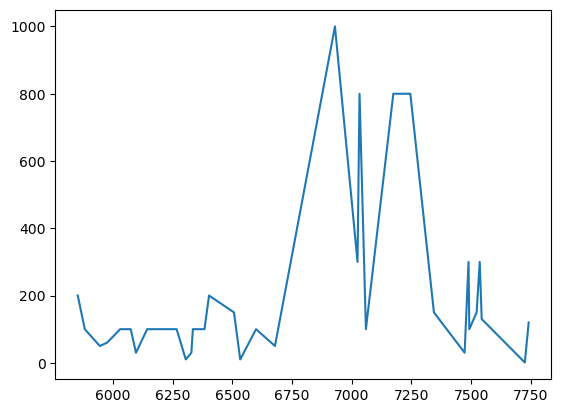

In [109]:
path = "Astrowoche2025/Ne_spec.csv"
# CSV einlesen
ref = pd.read_csv(path)

# In float konvertieren (alles Nicht-Numerische wird NaN)
ref["Wavelength (angstrom)"] = pd.to_numeric(ref["Wavelength (angstrom)"], errors="coerce")
ref["Intensity"] = pd.to_numeric(ref["Intensity"], errors="coerce")

# Zeilen mit kaputten Werten wegwerfen
ref = ref.dropna(subset=["Wavelength (angstrom)", "Intensity"])

# Jetzt erst filtern
ref = ref[(ref["Wavelength (angstrom)"] > 5500) & 
            (ref["Wavelength (angstrom)"] < 8000)]

wavelength = ref["Wavelength (angstrom)"].to_numpy(dtype=np.float64)
intensity  = ref["Intensity"].to_numpy(dtype=np.float64)

ref_w = wavelength
ref_w_diff = np.diff(ref_w)
ref_I = intensity

plt.plot(ref_w, ref_I)

# Reference Spectrum Vega

In [9]:
from astropy.io import fits

path = "Astrowoche2025/alpha_lyr_mod_004.fits"

with fits.open(path) as hdul:
    header = hdul["SCI"].header
    data   = hdul["SCI"].data
    
    print(data.names)   # Spaltennamen

    # Einheiten pro Spalte
    for i, name in enumerate(data.names, start=1):
        unit = header.get(f"TUNIT{i}")
        print(name, "->", unit)


['WAVELENGTH', 'FLUX', 'CONTINUUM']
WAVELENGTH -> ANGSTROMS
FLUX -> FLAM
CONTINUUM -> FLAM


Filename: Astrowoche2025/alpha_lyr_mod_004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      30   ()      
  1  SCI           1 BinTableHDU     23   8094R x 3C   [1D, 1E, 1E]   
['WAVELENGTH', 'FLUX', 'CONTINUUM']


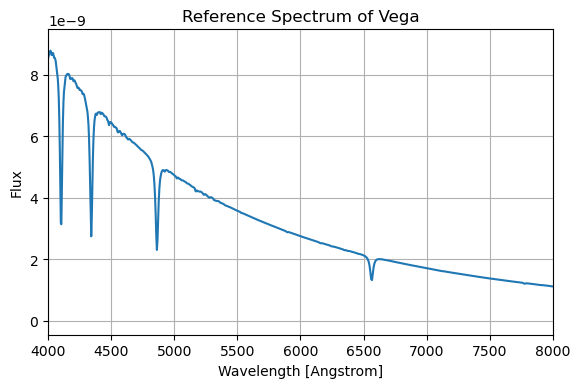

[9.00388727e+02 9.01291391e+02 9.02194936e+02 ... 2.98765844e+06
 2.99065357e+06 2.99365170e+06]


In [10]:
from astropy.io import fits

path_vega = "Astrowoche2025/alpha_lyr_mod_004.fits"

fits.info(path_vega)


with fits.open(path_vega) as hdul:
    tab = hdul["SCI"].data          # oder hdul[1].data
    print(tab.names) 

lam_vega  = tab["WAVELENGTH"]   # Beispielname
flux_vega = tab["FLUX"]


cm = 1/2.54
plt.figure(figsize=(15*cm,10*cm))
plt.plot(lam_vega, flux_vega)
plt.xlim(4000, 8000)
plt.xlabel("Wavelength [Angstrom]")
plt.ylabel("Flux")
plt.tight_layout()
plt.grid()
plt.title("Reference Spectrum of Vega")
plt.show()

print(lam_vega)


# Evaluation Stars

## 1. Night, 1. Calibration

### Wavelength calibration

shift: 690
2370


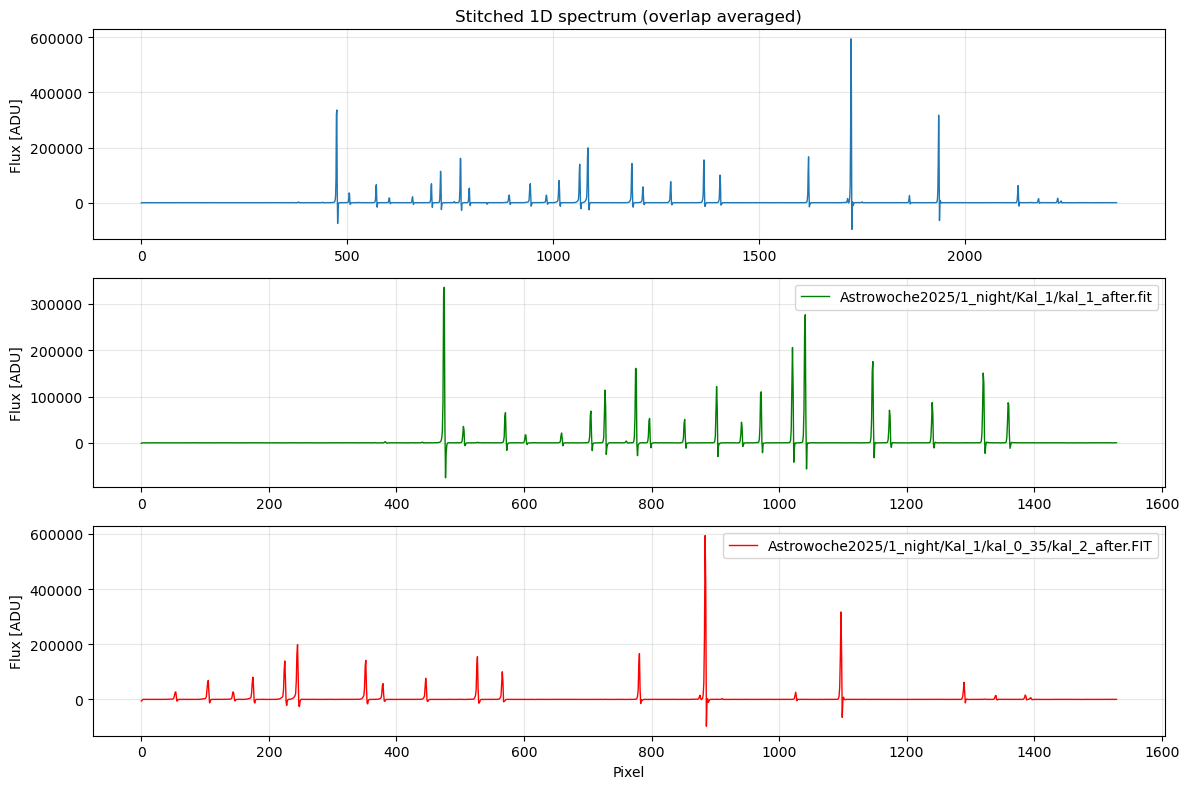

484
Scal: None
inliers: 12 coeff: [9.61940625e-01 5.39556610e+03]


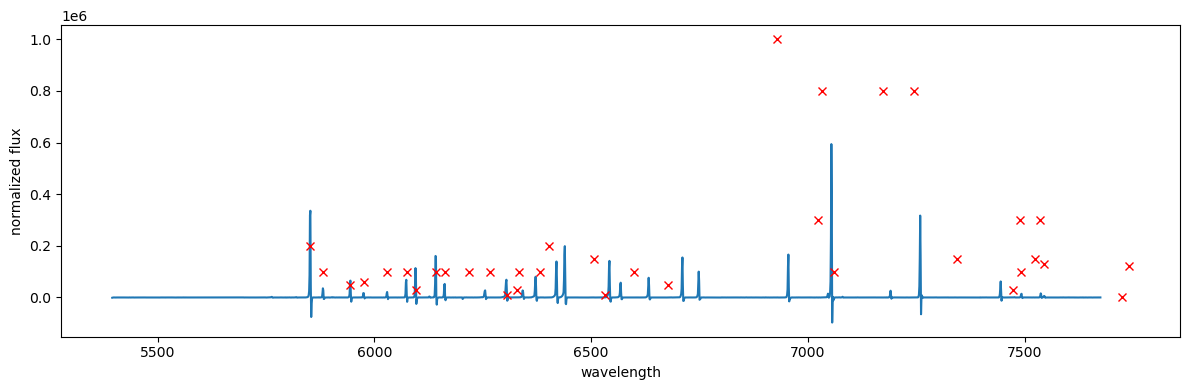

[5852.4879 5881.8952 5944.8342 5975.534  6029.9969 6074.3377 6096.1631
 6143.0626 6163.5939 6217.2812 6266.495  6304.7889 6328.1646 6334.4278
 6382.9917 6402.248  6506.5281 6532.8822 6598.9529 6678.2762 6929.4673
 7024.0504 7032.4131 7059.1074 7173.9381 7245.1666 7343.945  7472.4386
 7488.8712 7492.102  7522.818  7535.7741 7544.0443 7724.6233 7740.738 ]
[5852.4879     5881.34611875 5944.8342     5974.65435938 6029.484975
 6073.73424375 6094.8969375  6126.64097813 6141.0700875  6162.23278125
 6255.54102188 6304.59999375 6342.11567813 6371.9358375  6420.03286875
 6439.27168125 6542.19932813 6568.171725   6632.62174688 6710.5389375
 6748.05462188 6954.87185625 7046.25621563 7053.95174063 7190.54730938
 7258.84509375 7262.69285625 7444.49963438 7492.59666563 7536.84593438
 7544.54145938]


In [219]:

path1 = "Astrowoche2025/1_night/Kal_1/kal_1_after.fit"
path2 = "Astrowoche2025/1_night/Kal_1/kal_0_35/kal_2_after.FIT"

# shift_1night_1 = 700
x_comb, s_comb, shift_1night_1, x1, s1, x2, s2, scal = combine_spec(path1, path2, plot = True, guess = 750)
# x_comb, s_comb, shift, x1, s1, x2, s2, scal = combine_spec(path1, path2, plot = True, shift = shift_1night_1)
print(shift)
print("Scal:", scal)

ninl, coeff_1night_1 = calibrate_with_anchor(x_comb, s_comb, ref_w, tol=1.5)
print("inliers:", ninl, "coeff:", coeff_1night_1)

lam_axis = np.polyval(coeff_1night_1, x_comb)
peaks, props = find_peaks(s_comb,height = 3000)
plt.figure(figsize=(12,4))
plt.plot(lam_axis ,s_comb,   ms=6)
plt.plot(ref_w, ref_I*1000, "rx")
plt.xlabel("wavelength")
plt.ylabel("normalized flux")
plt.tight_layout()
plt.show()

print(ref_w)
print(lam_axis[peaks])


### Rigel

Astrowoche2025/1_night/Kal_1/Rigel_2\rigel_spec_2.FIT
1530
Astrowoche2025/1_night/Kal_1/Rigel_2\rigel_spec_2_backup.FIT
1530
Astrowoche2025/1_night/Kal_1/Rigel_2\rigel_spec_2_backup_2.FIT
1530
2370


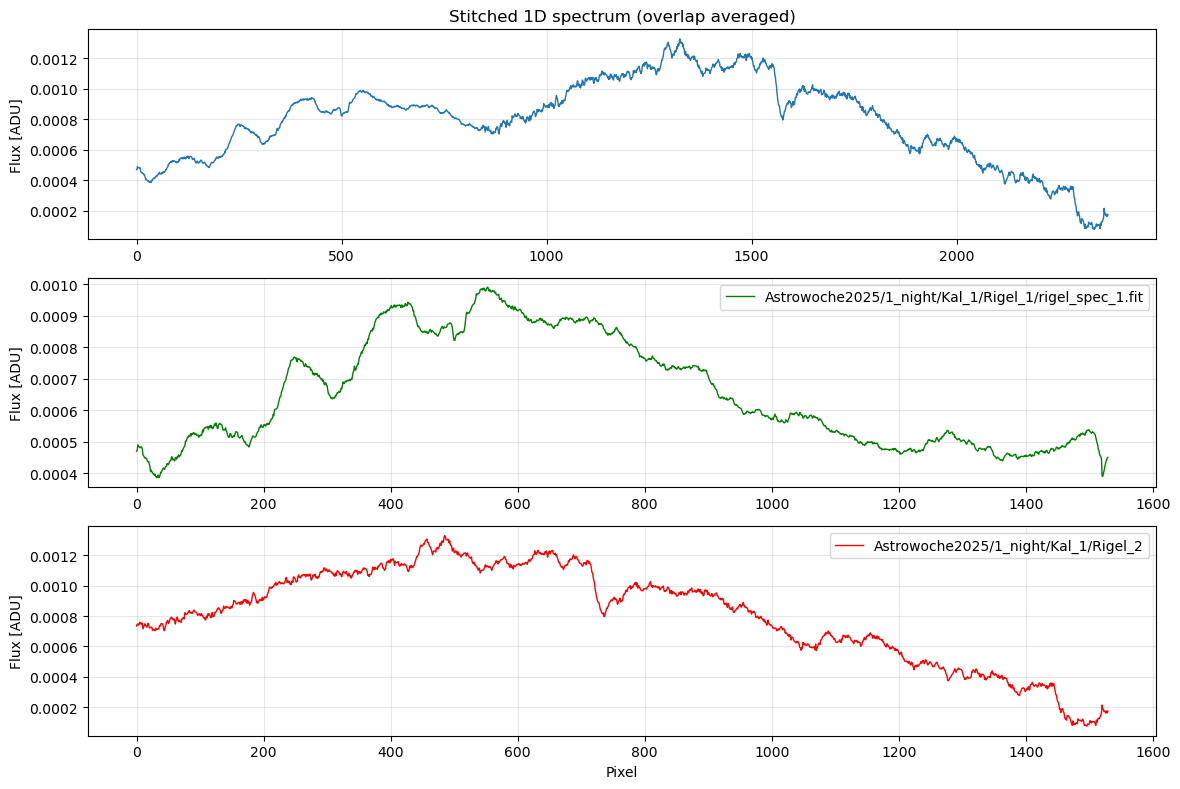

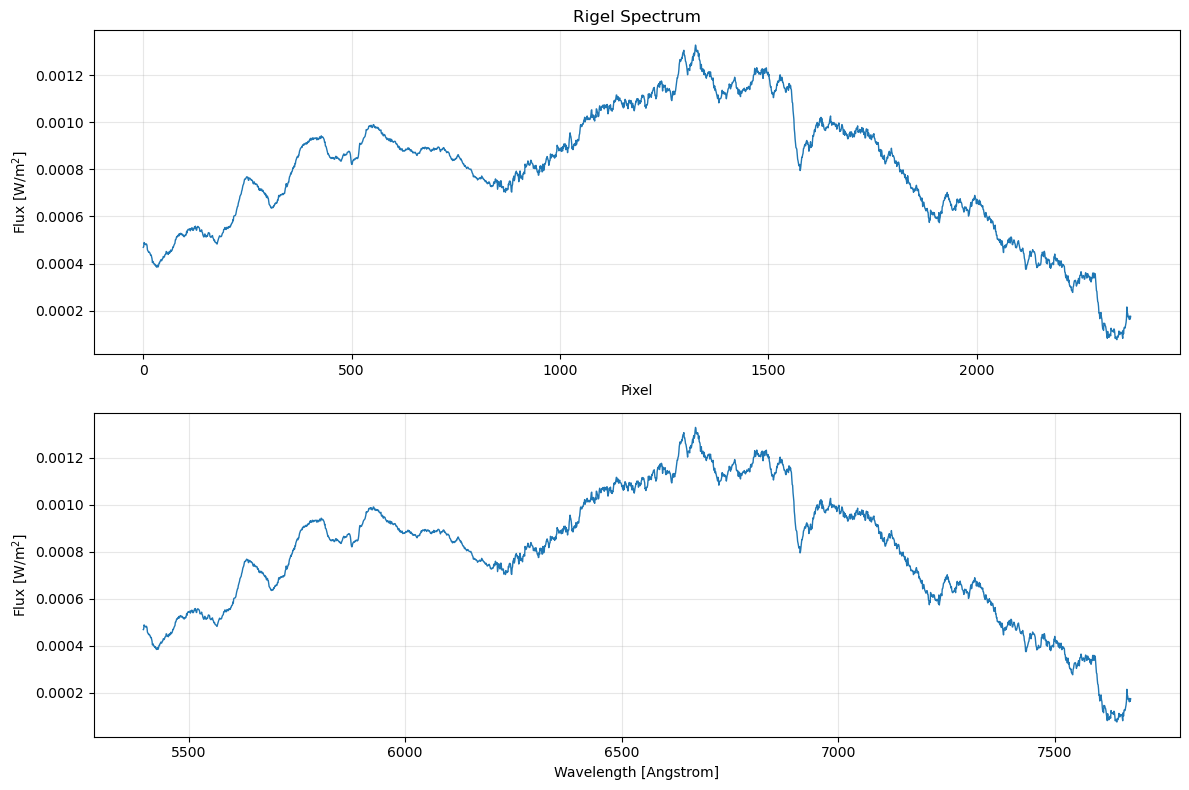

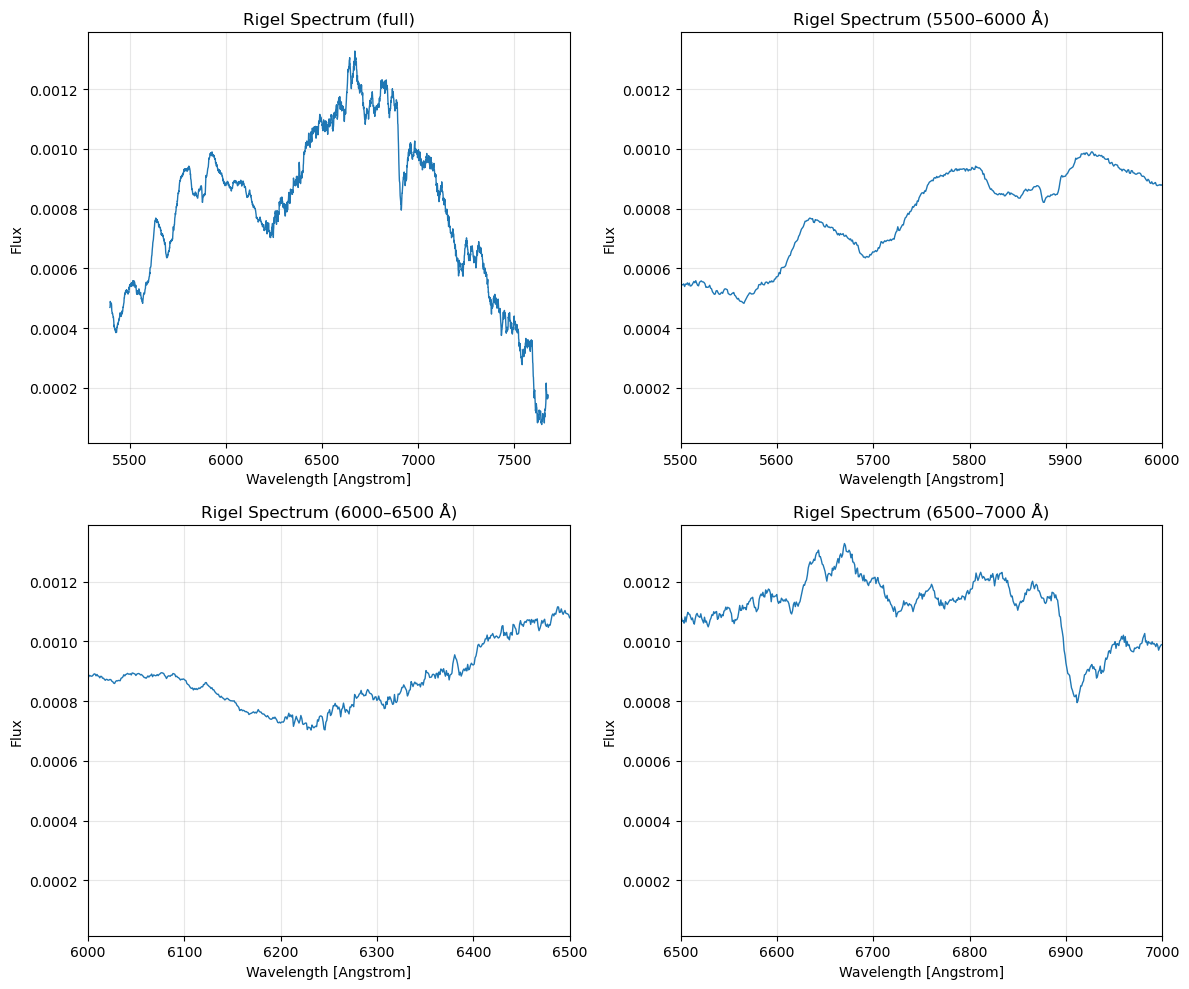

In [220]:
path1 = "Astrowoche2025/1_night/Kal_1/Rigel_1/rigel_spec_1.fit"
path2 = "Astrowoche2025/1_night/Kal_1/Rigel_2"


x_comb_rigel, s_comb_rigel, *rest = combine_spec(path1, path2, folder2 =True, plot = True, scal = 1, shift = shift_1night_1, filtering = True, delta = 10, normalize = True)
lam_axis_rigel = np.polyval(coeff_1night_1, x_comb_rigel)
plot_spectrum(x_comb_rigel, lam_axis_rigel, s_comb_rigel, "Rigel Spectrum")

### Capella

Astrowoche2025/1_night/Kal_1/Capella_2\capella_spec_2.FIT
1530
Astrowoche2025/1_night/Kal_1/Capella_2\capella_spec_2_backup.FIT
1530
Astrowoche2025/1_night/Kal_1/Capella_2\capella_spec_2_backup_2.FIT
1530
2370


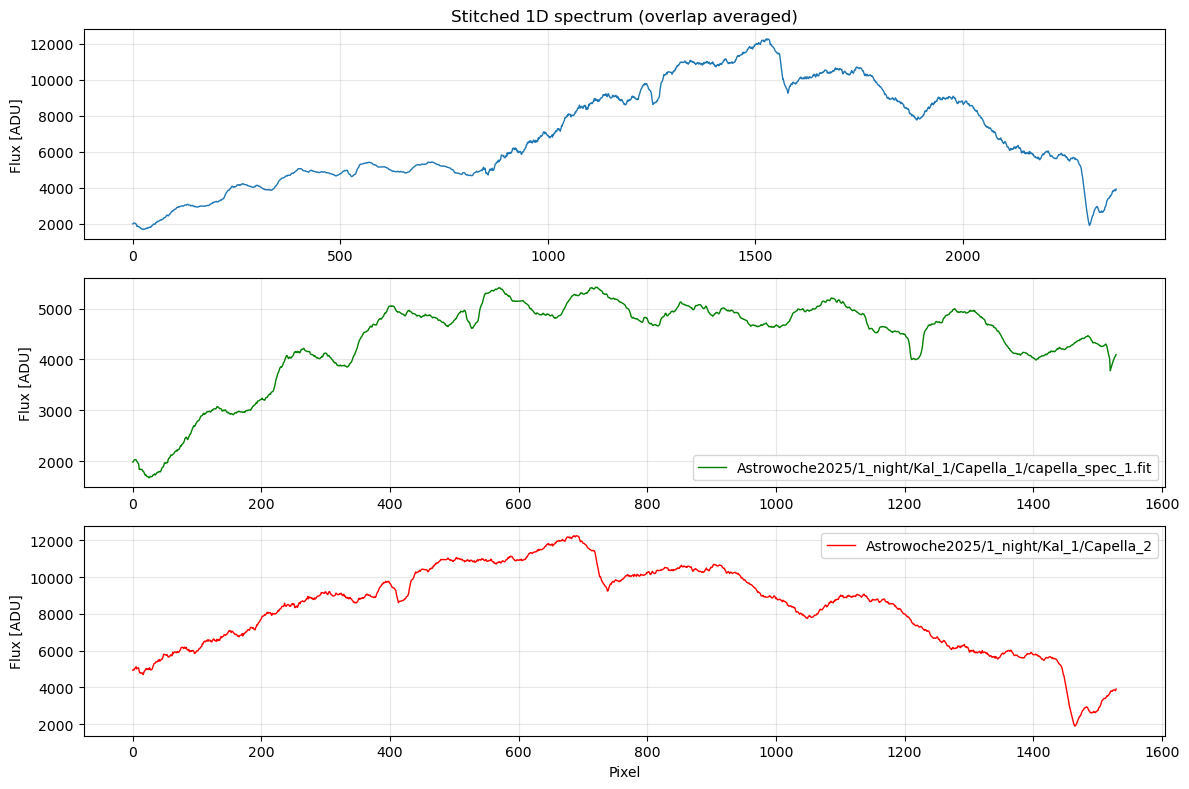

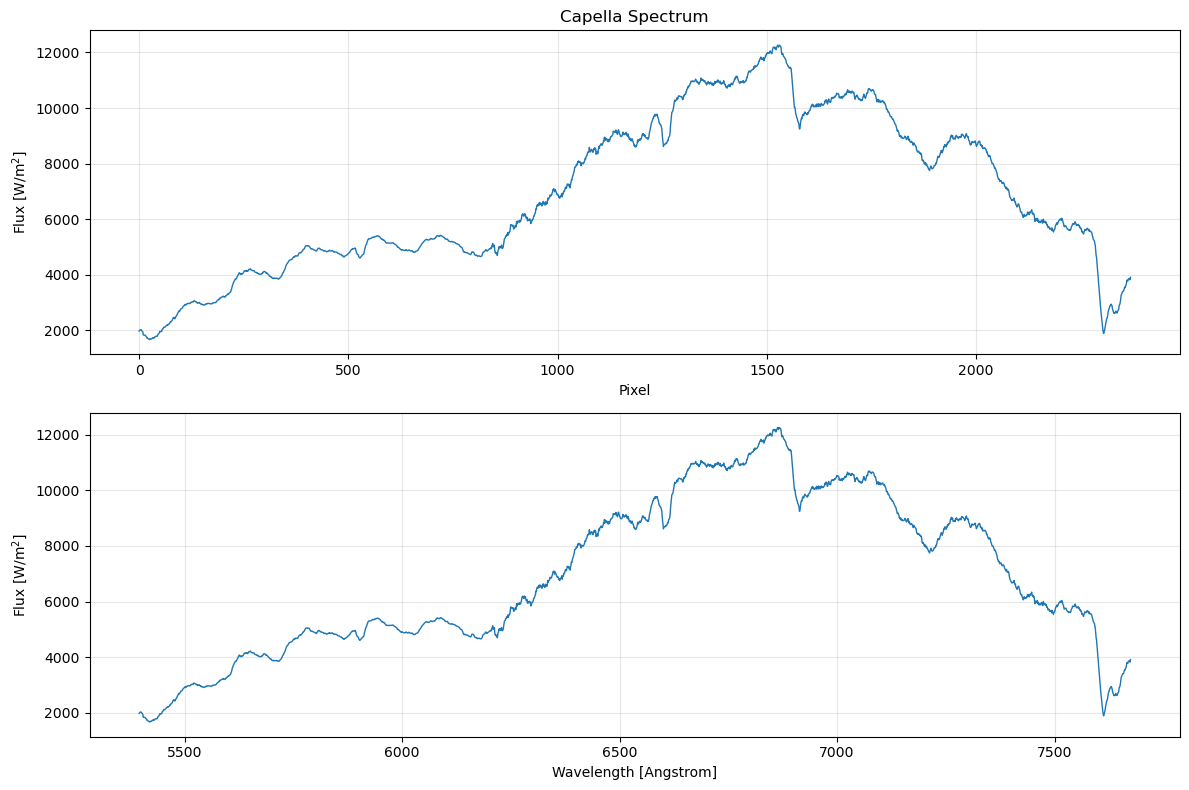

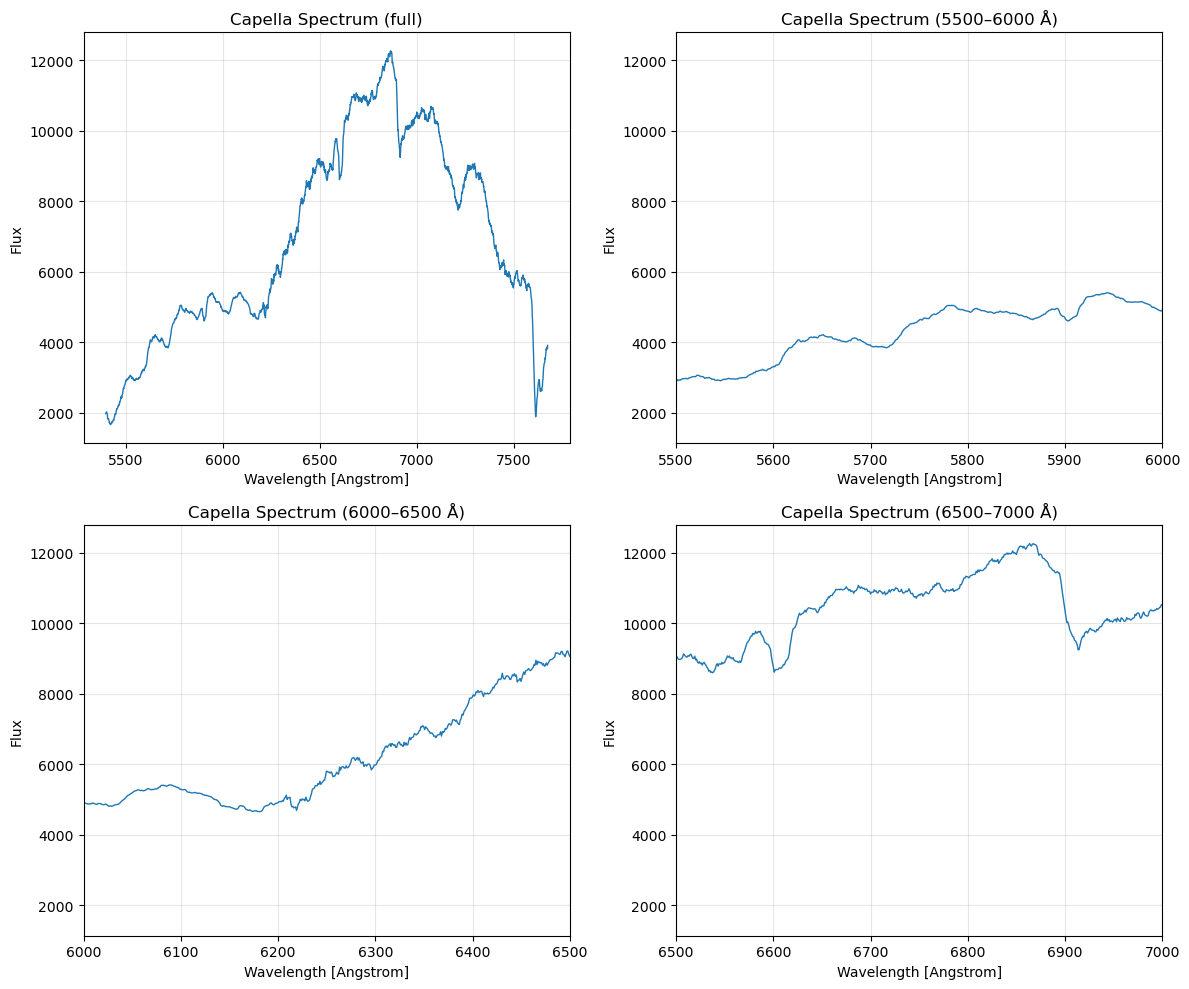

In [221]:
path1 = "Astrowoche2025/1_night/Kal_1/Capella_1/capella_spec_1.fit"
path2 = "Astrowoche2025/1_night/Kal_1/Capella_2"

x_comb_capella, s_comb_capella, *rest = combine_spec(path1, path2, folder2=True, plot = True, scal = 1, filtering = True, shift = shift_1night_1, delta = 10)
lam_axis_capella = np.polyval(coeff_1night_1, x_comb_capella)
plot_spectrum(x_comb_capella, lam_axis_capella, s_comb_capella, "Capella Spectrum")

### Mirfak

Astrowoche2025/1_night/Kal_1/mirfak_2\mirfak_spec_2.FIT
1530
Astrowoche2025/1_night/Kal_1/mirfak_2\mirfak_spec_2_backup.FIT
1530
Astrowoche2025/1_night/Kal_1/mirfak_2\mirfak_spec_2_backup_2.FIT
1530
2370


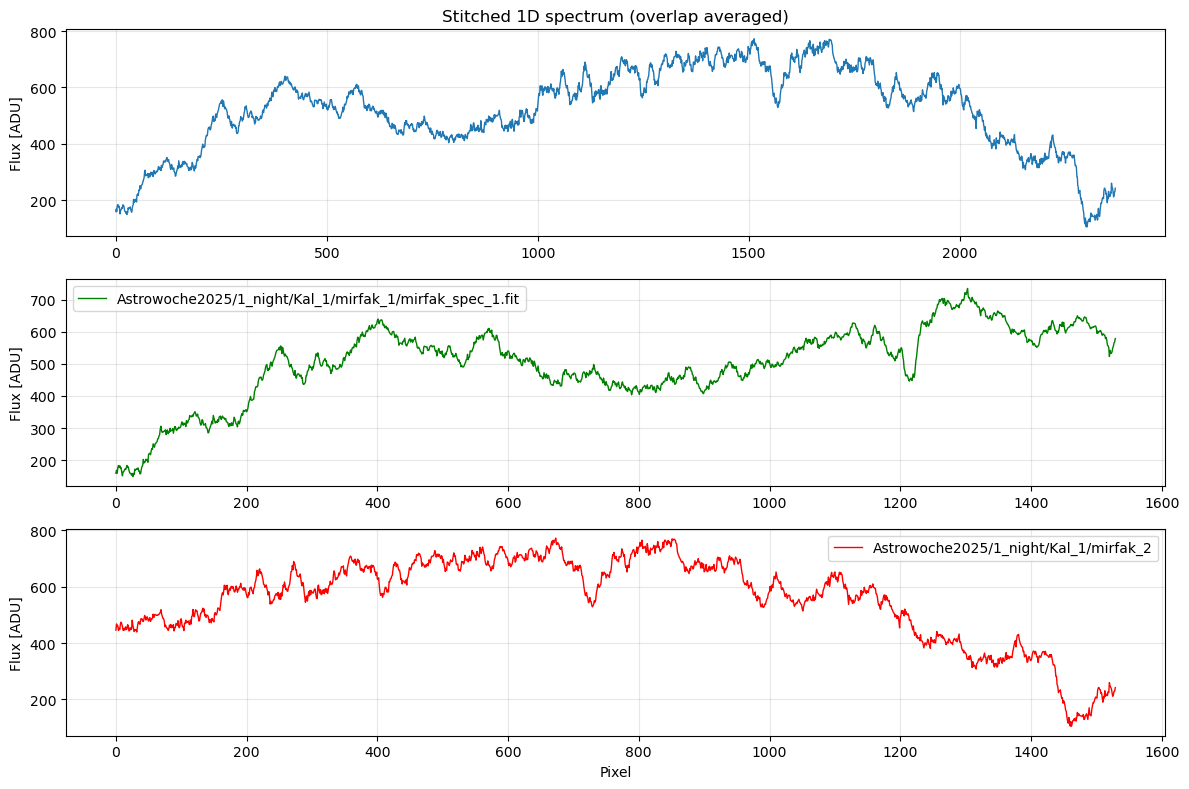

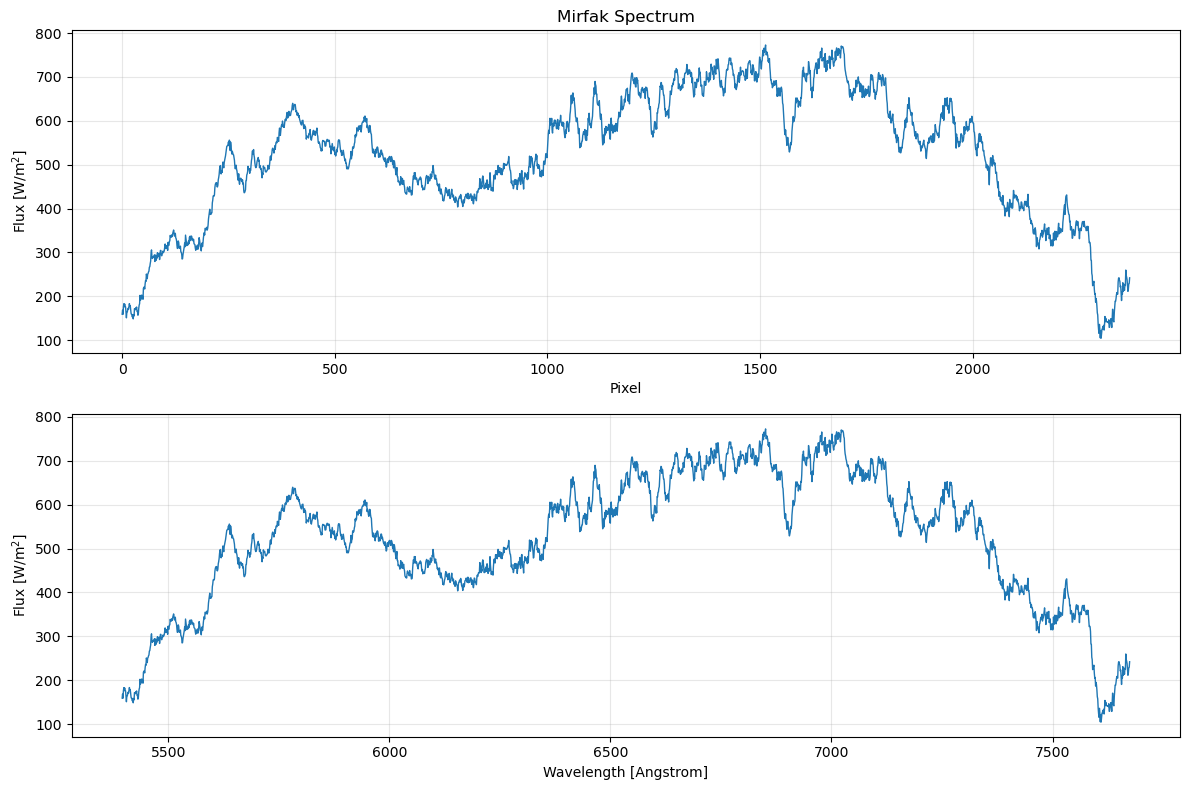

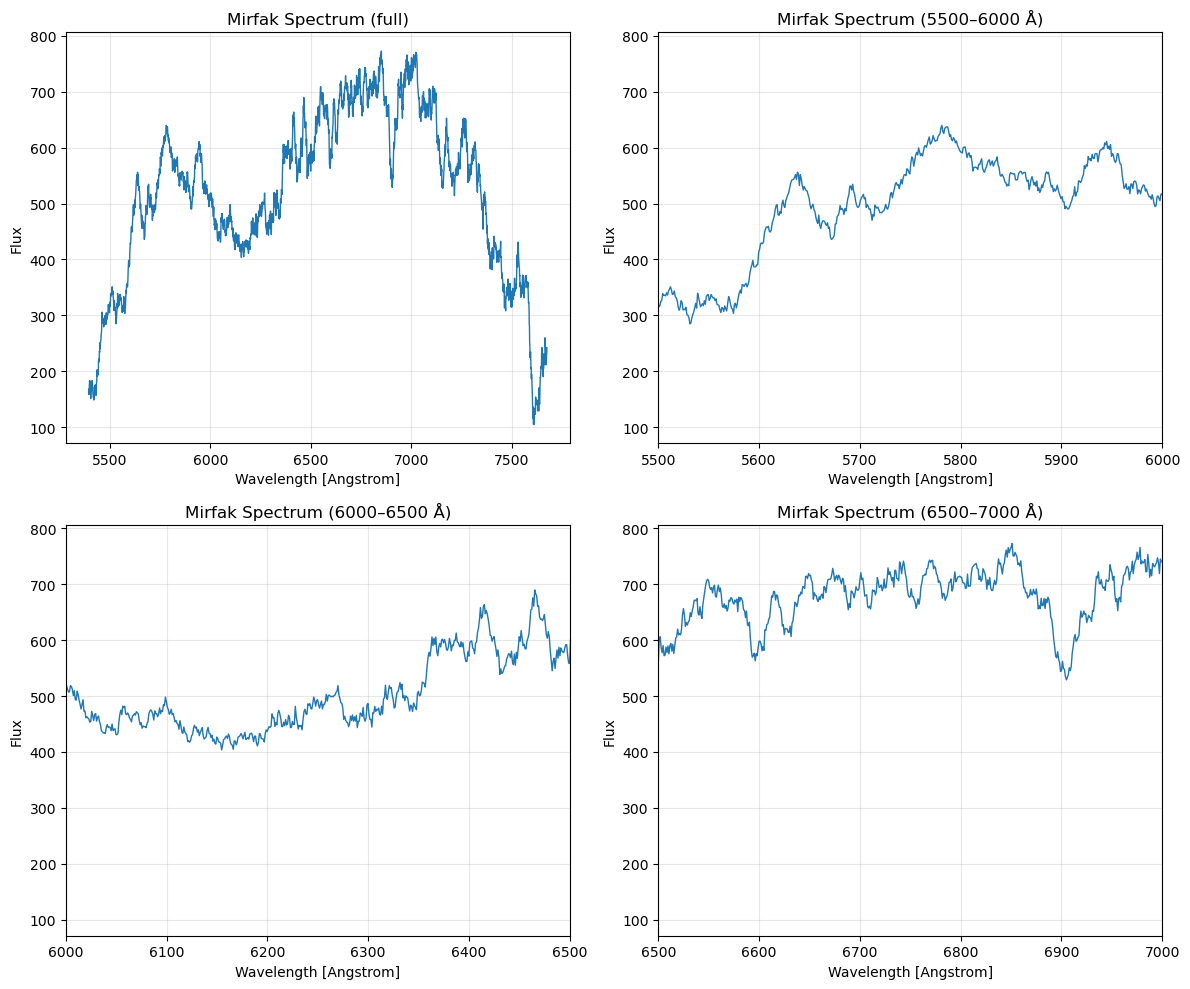

In [222]:
path1 = "Astrowoche2025/1_night/Kal_1/mirfak_1/mirfak_spec_1.fit"
path2 = "Astrowoche2025/1_night/Kal_1/mirfak_2"

x_comb_mirfak, s_comb_mirfak, *rest = combine_spec(path1, path2, folder2=True, plot = True, scal = 1,filtering = True ,shift = shift_1night_1, delta = 10)
lam_axis_mirfak = np.polyval(coeff_1night_1, x_comb_mirfak)
plot_spectrum(x_comb_mirfak, lam_axis_mirfak, s_comb_mirfak, "Mirfak Spectrum")

### Pollux

Astrowoche2025/1_night/Kal_1/pollux_2\pollux_spec_2.FIT
1530
2370


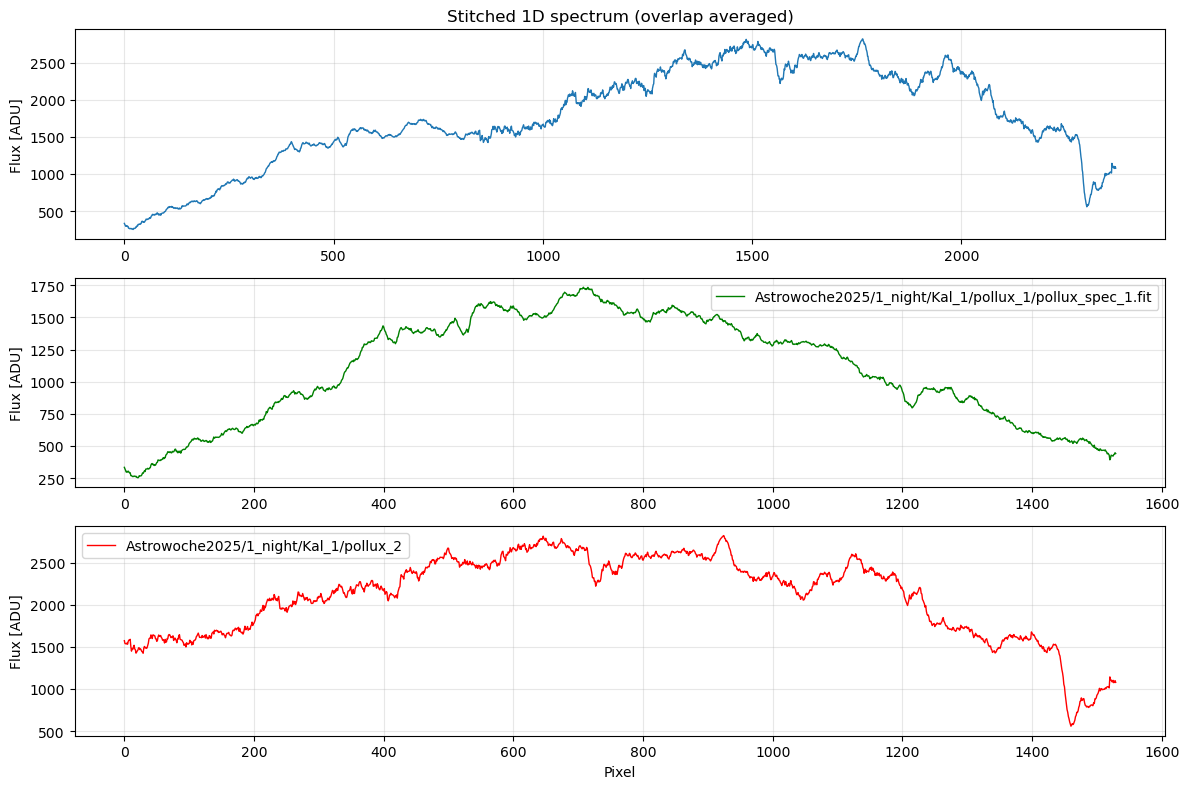

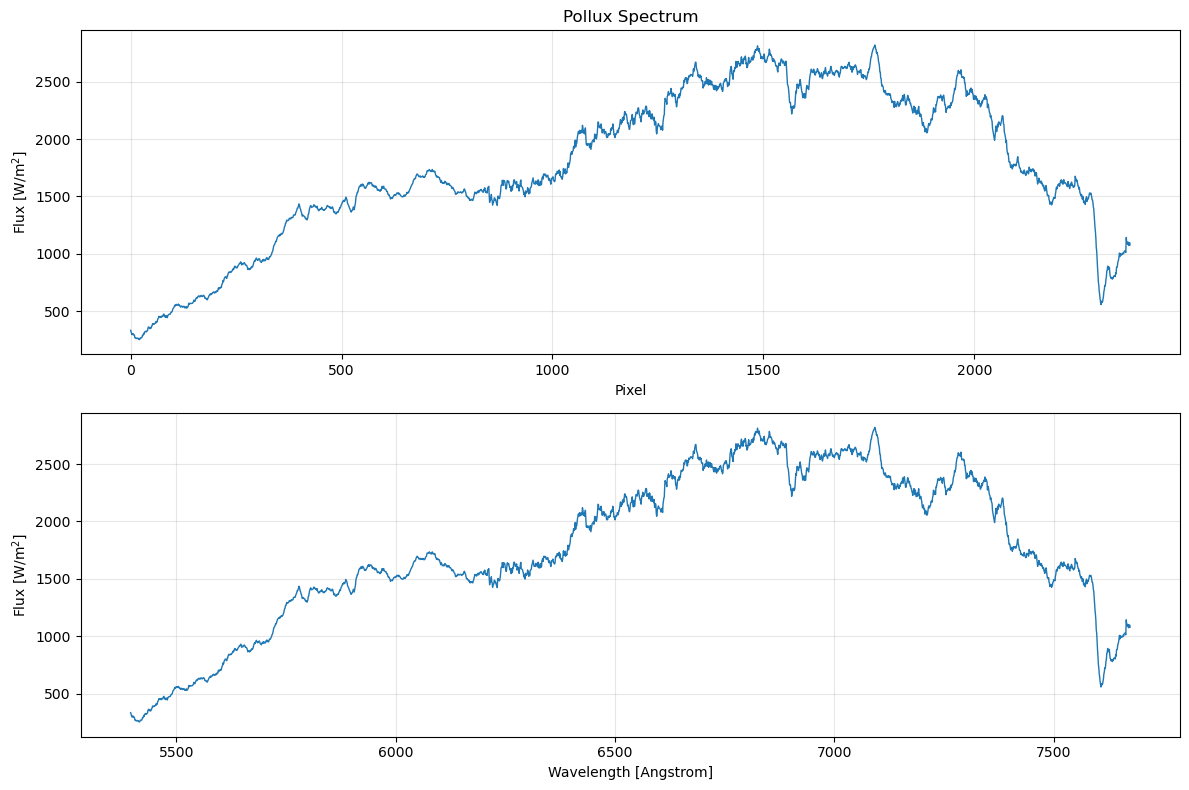

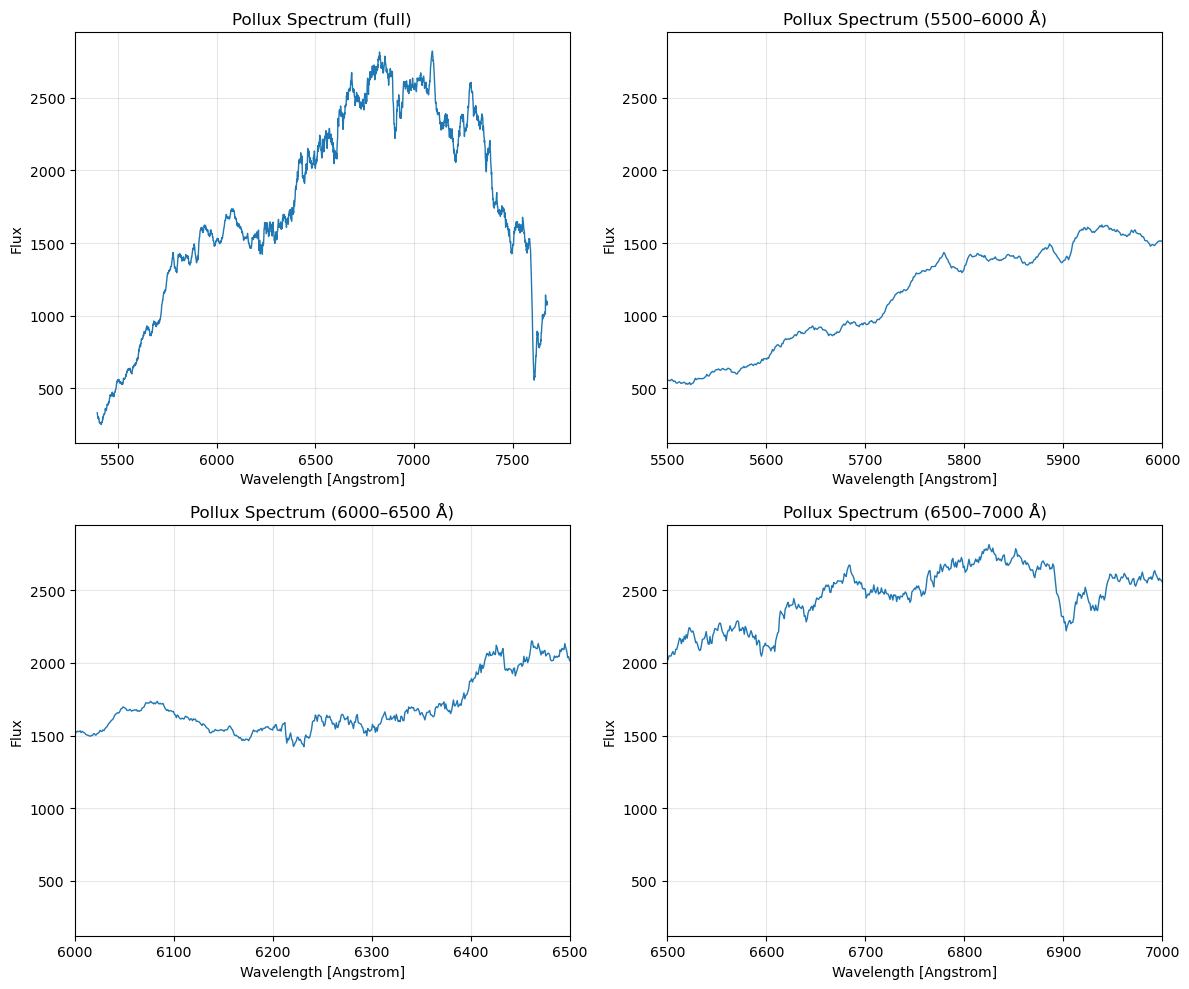

In [223]:
path1 = "Astrowoche2025/1_night/Kal_1/pollux_1/pollux_spec_1.fit"
path2 = "Astrowoche2025/1_night/Kal_1/pollux_2"

x_comb_pollux, s_comb_pollux, *rest = combine_spec(path1, path2, folder2=True, plot = True,scal = 1, shift = shift_1night_1, filtering = True, delta = 10)
lam_axis_pollux = np.polyval(coeff_1night_1, x_comb_pollux)
plot_spectrum(x_comb_pollux, lam_axis_pollux, s_comb_pollux, "Pollux Spectrum")

## 1. Night second round

### calibration

Astrowoche2025/1_night/Kal_2/kal_1_25\kal_1_25.FIT
1530
Astrowoche2025/1_night/Kal_2/kal_1_25\kal_1_25_after.FIT
1530
Astrowoche2025/1_night/Kal_2/kal_0_35\kal_0_35.FIT
1530
Astrowoche2025/1_night/Kal_2/kal_0_35\kal_0_35_after.FIT
1530
shift: 1021
2039


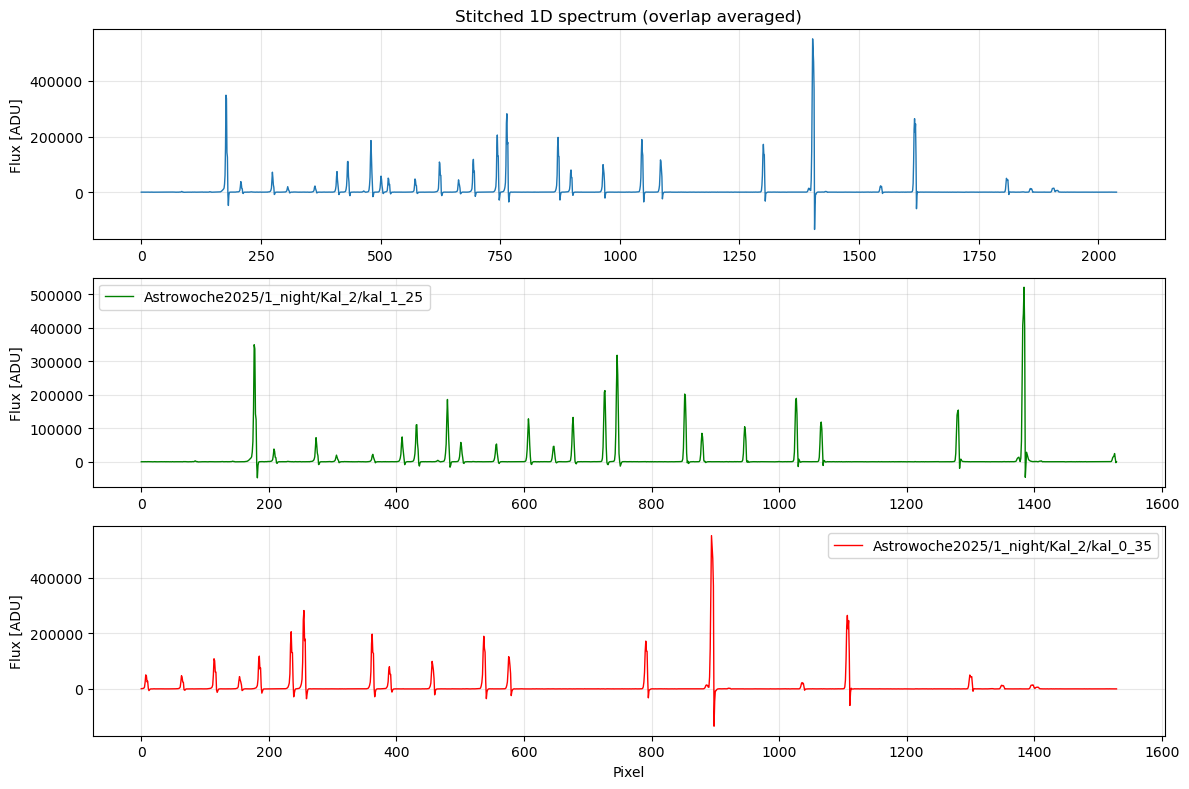

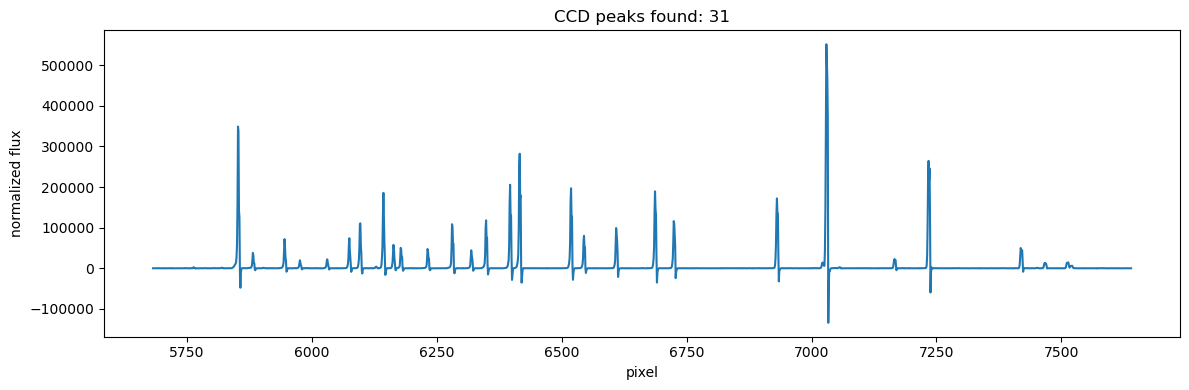

In [224]:

path1 = "Astrowoche2025/1_night/Kal_2/kal_1_25"
path2 = "Astrowoche2025/1_night/Kal_2/kal_0_35"

# shift_1night_2 = 1100

x_comb, s_comb, shift_1night_2, x1, s1, x2, s2, scal = combine_spec(path1, path2,folder1 = True, folder2 = True, plot = True, guess = 1000)
ninl, coeff_night1_2 = calibrate_with_anchor(x_comb, s_comb, ref_w, tol=1.5)
# print("inliers:", ninl, "coeff:", coeff)

lam_axis = np.polyval(coeff_night1_2, x_comb)


plt.figure(figsize=(12,4))
# plt.plot(x_comb, s_comb, lw=1)
plt.plot(lam_axis ,s_comb,  ms=6)
plt.title(f"CCD peaks found: {len(peaks)}")
plt.xlabel("pixel")
plt.ylabel("normalized flux")
plt.tight_layout()
plt.show()

# print(lam_axis[peaks])


### Bellatrix

Astrowoche2025/1_night/Kal_2/Bellatrix_1\bellatrix_spec_1.FIT
1530
Astrowoche2025/1_night/Kal_2/Bellatrix_1\bellatrix_spec_1_backup.FIT
1530
Astrowoche2025/1_night/Kal_2/Bellatrix_1\bellatrix_spec_1_backup_2.FIT
1530
Astrowoche2025/1_night/Kal_2/Bellatrix_2\bellatrix_spec_2.FIT
1530
Astrowoche2025/1_night/Kal_2/Bellatrix_2\bellatrix_spec_2_backup.FIT
1530
Astrowoche2025/1_night/Kal_2/Bellatrix_2\bellatrix_spec_2_backup_2.FIT
1530
2039


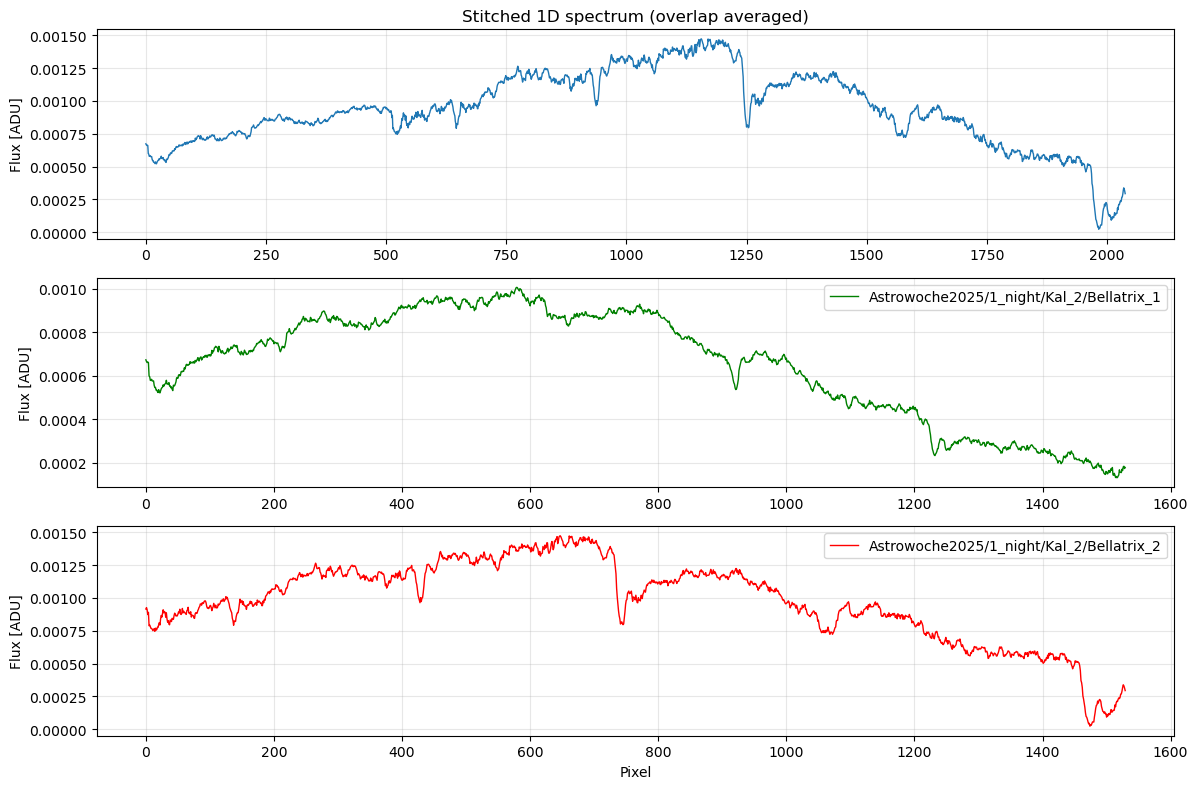

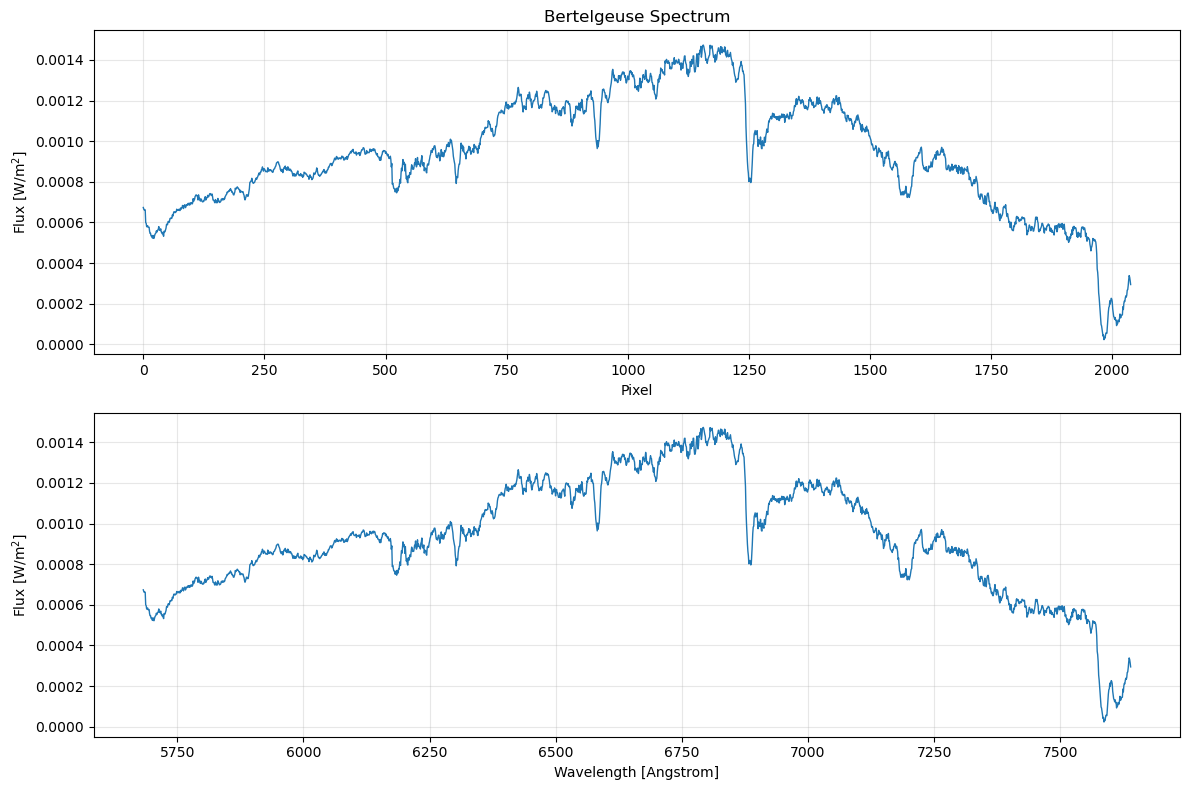

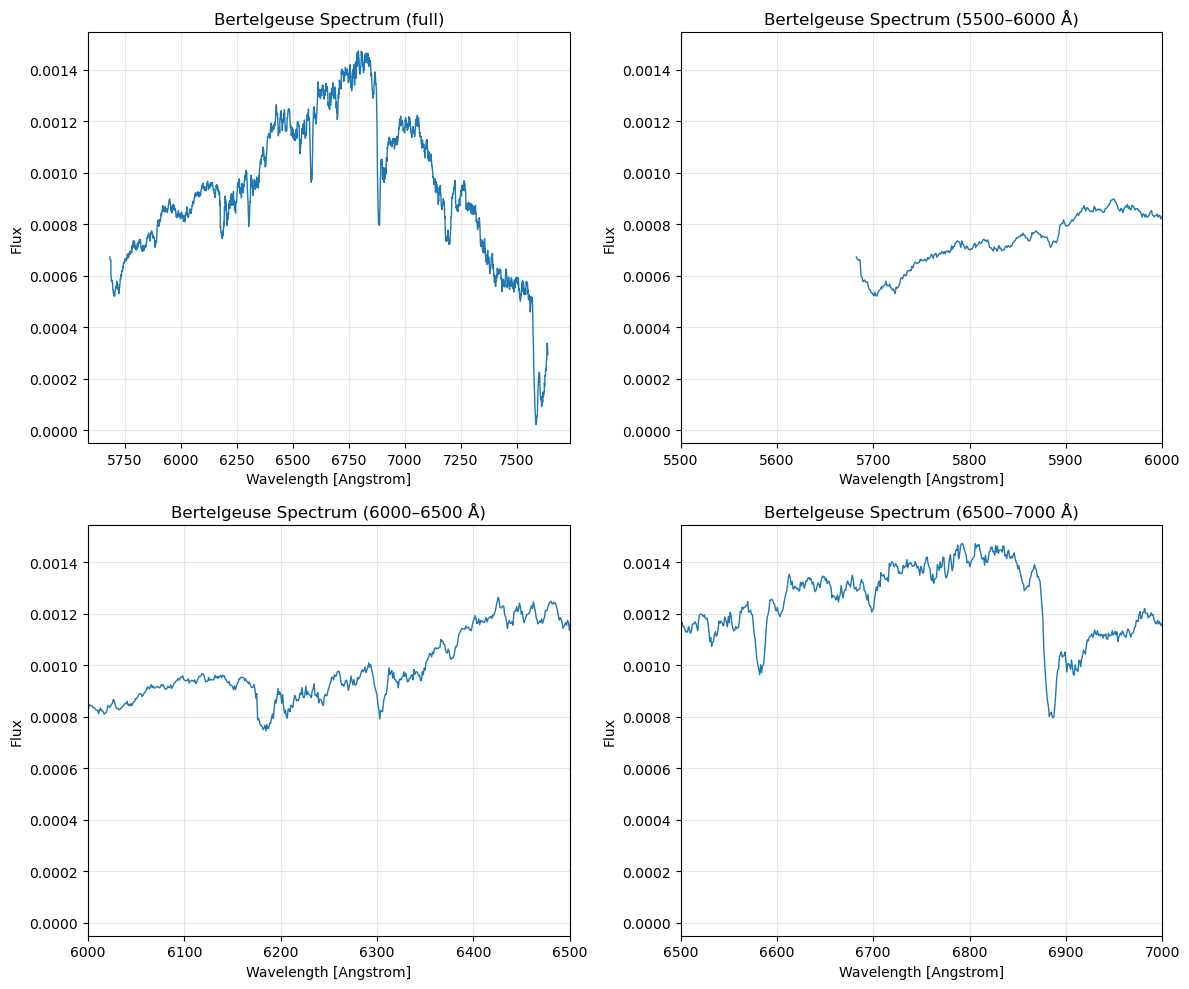

In [228]:
path1 = "Astrowoche2025/1_night/Kal_2/Bellatrix_1"
path2 = "Astrowoche2025/1_night/Kal_2/Bellatrix_2"


x_comb_pollux, s_comb_pollux, *rest = combine_spec(path1, path2, folder1 = True, folder2=True, plot = True, scal= 1, shift = shift_1night_2, filtering = True, delta = 5, normalize = True)
lam_axis_pollux = np.polyval(coeff_night1_2, x_comb_pollux)
plot_spectrum(x_comb_pollux, lam_axis_pollux, s_comb_pollux, "Bertelgeuse Spectrum")



### Betelgeuse

Astrowoche2025/1_night/Kal_2/Betelgeuse_1\betelgeuse_spec_1.FIT
1530
Astrowoche2025/1_night/Kal_2/Betelgeuse_1\betelgeuse_spec_1_backup.FIT
1530
Astrowoche2025/1_night/Kal_2/Betelgeuse_1\betelgeuse_spec_1_backup_2.FIT
1530
Astrowoche2025/1_night/Kal_2/Betelgeuse_2\betelgeuse_spec_2.FIT
1530
Astrowoche2025/1_night/Kal_2/Betelgeuse_2\betelgeuse_spec_2_backup.FIT
1530
Astrowoche2025/1_night/Kal_2/Betelgeuse_2\betelgeuse_spec_2_backup_2.FIT
1530
2039


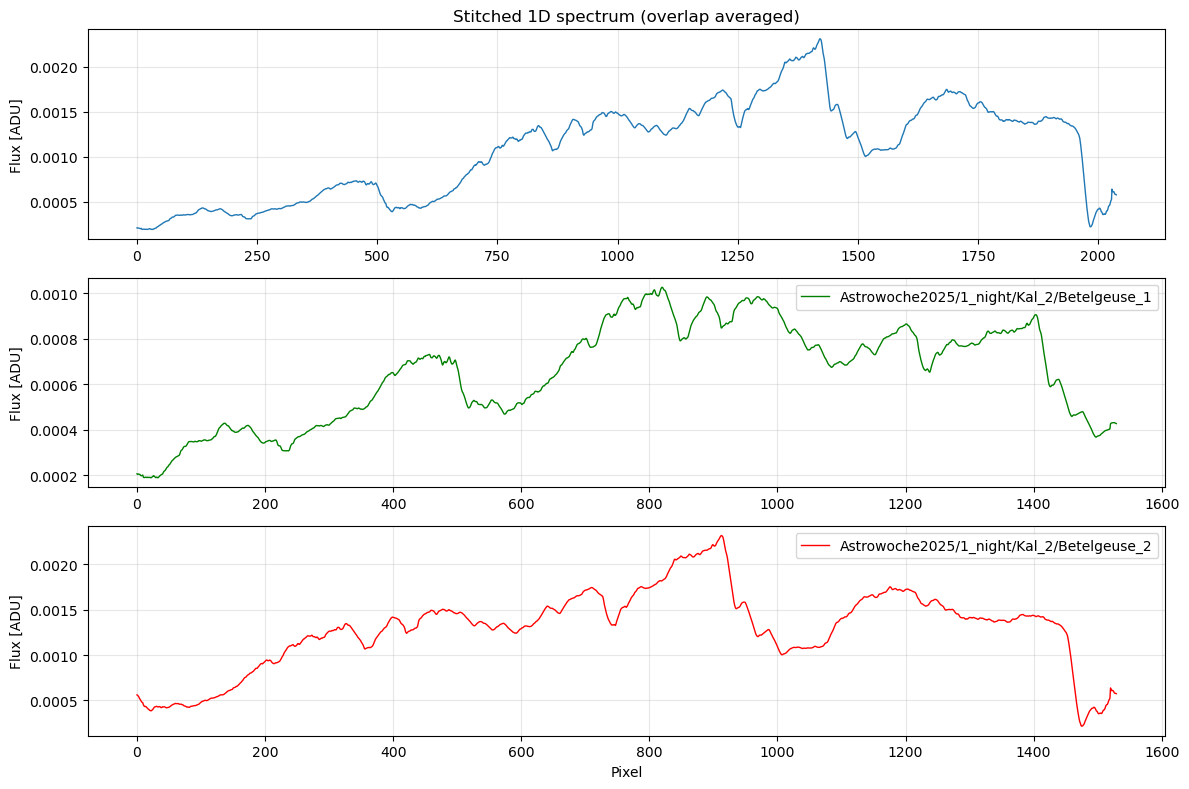

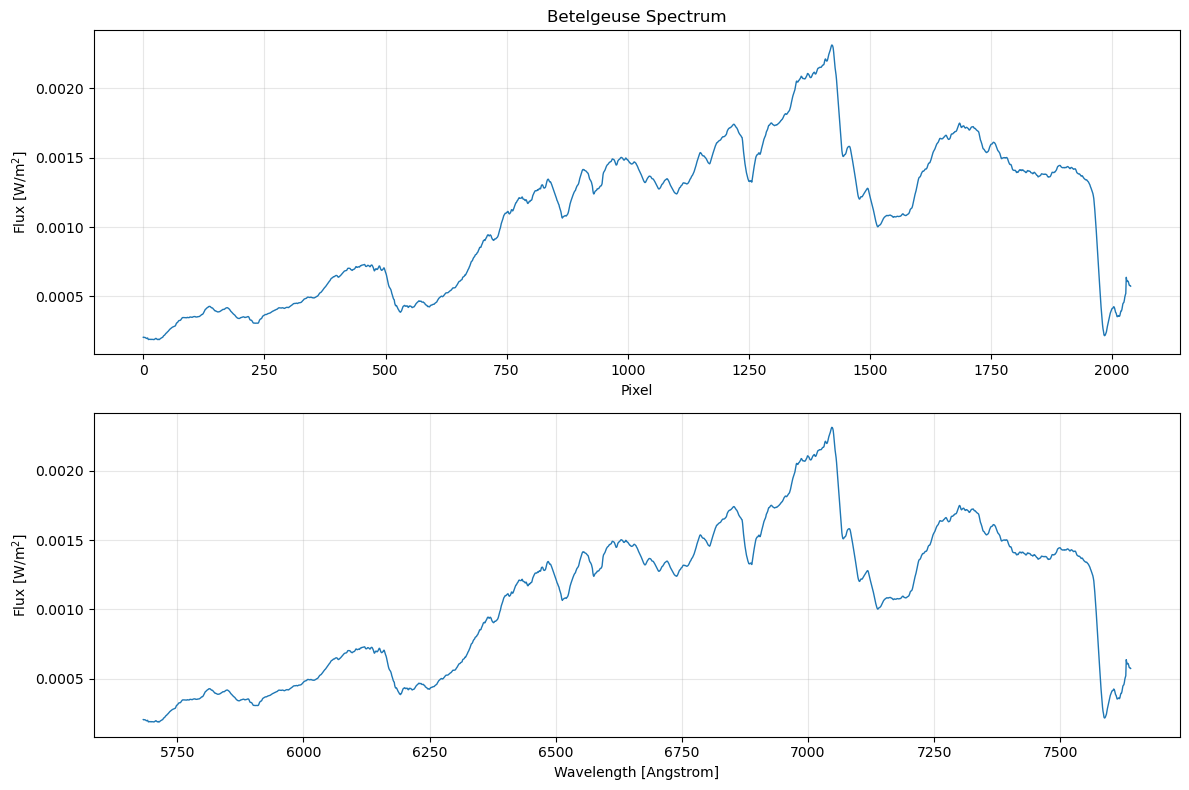

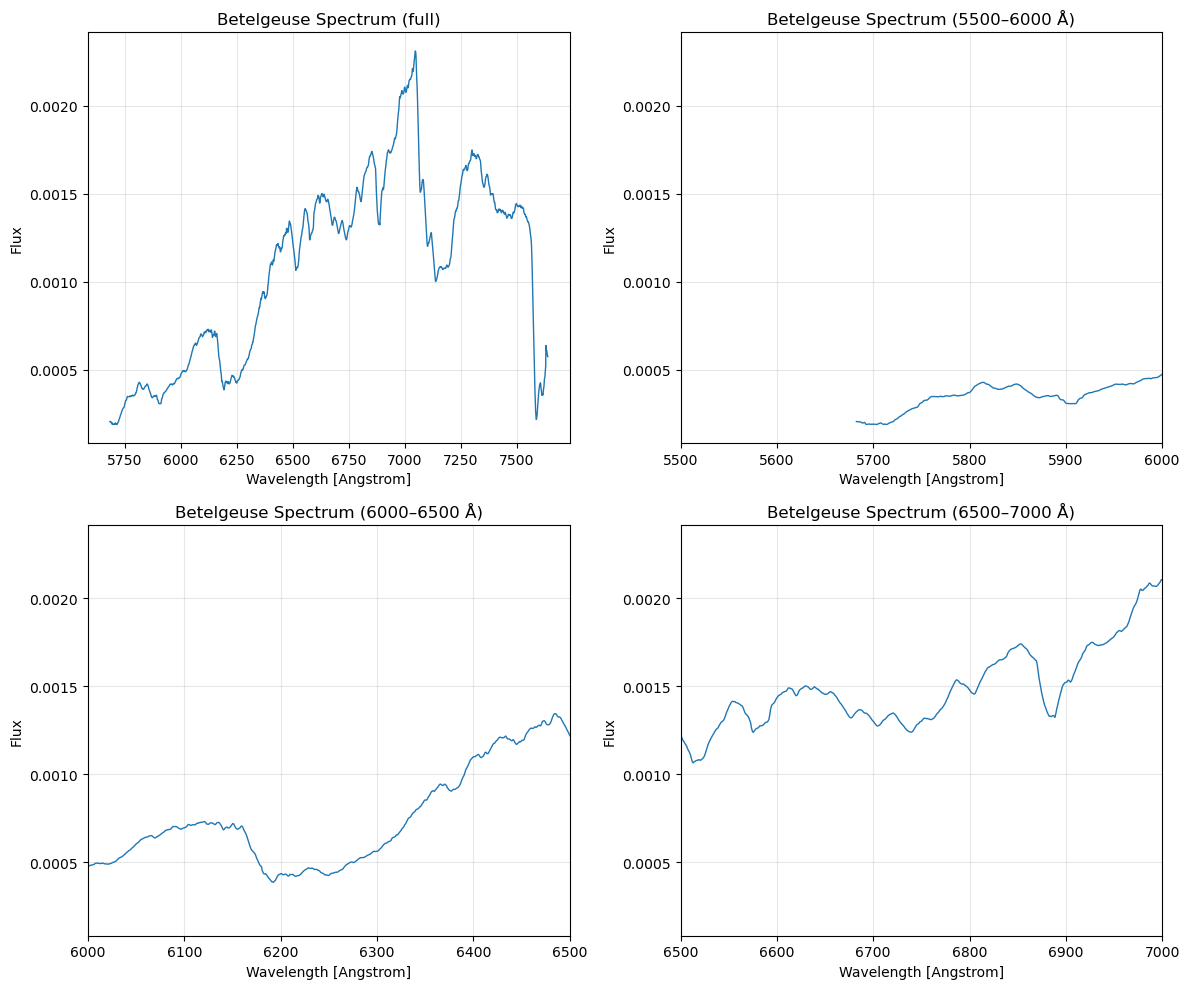

In [238]:
path1 = "Astrowoche2025/1_night/Kal_2/Betelgeuse_1"
path2 = "Astrowoche2025/1_night/Kal_2/Betelgeuse_2"


x_comb_pollux, s_comb_pollux, *rest = combine_spec(path1, path2, folder1 = True, folder2=True, plot = True, scal= 1, shift = shift_1night_2, filtering = True, delta = 10, normalize = True)
lam_axis_pollux = np.polyval(coeff_night1_2, x_comb_pollux)
plot_spectrum(x_comb_pollux, lam_axis_pollux, s_comb_pollux, "Betelgeuse Spectrum")



## 2. Night (zuerst 0_35 messung dann 1_25)

shift: 1048
2012


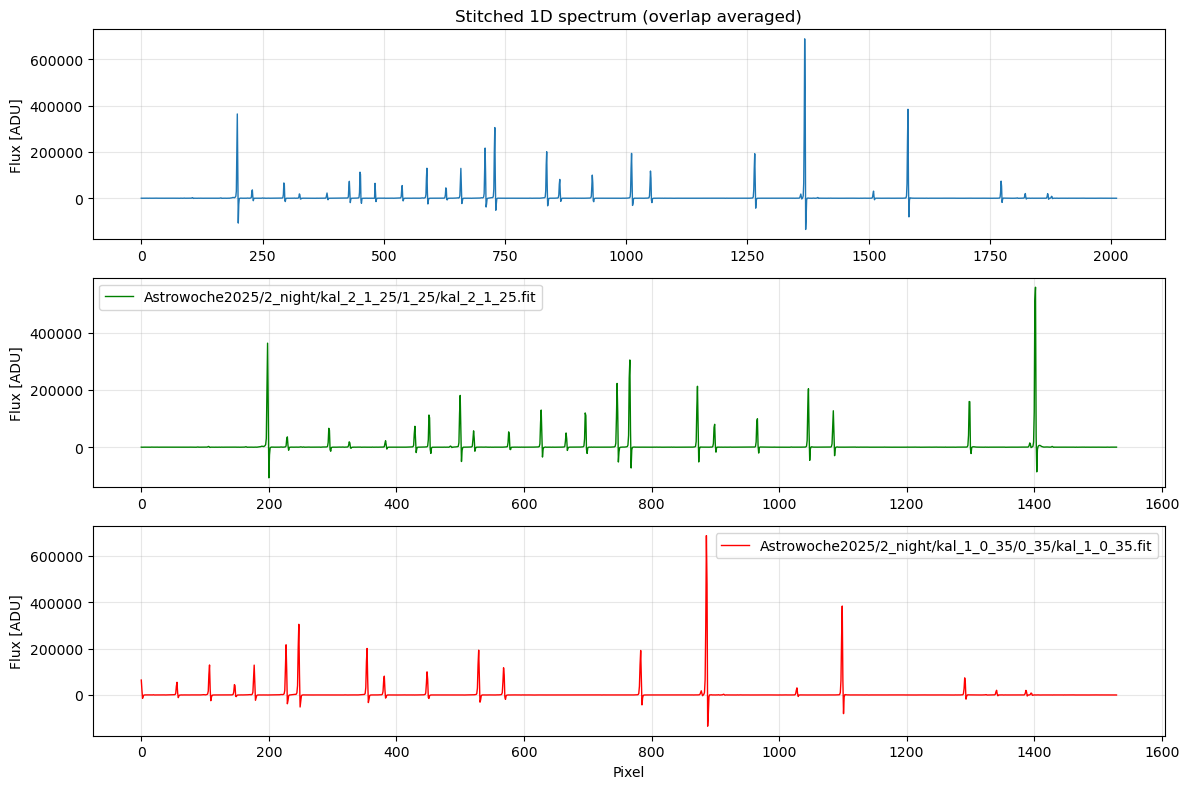

inliers: 8 coeff: [9.61940625e-01 5.66202366e+03]


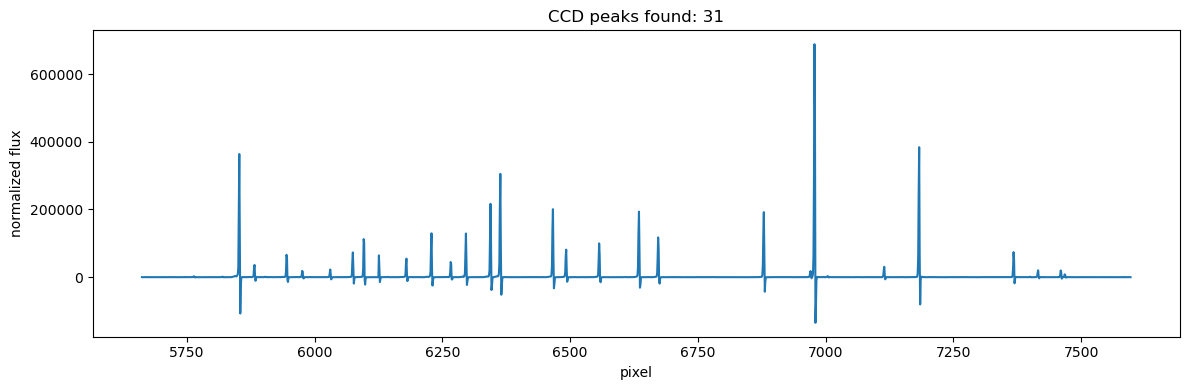

In [235]:


path2 = "Astrowoche2025/2_night/kal_1_0_35/0_35/kal_1_0_35.fit"
path1 = "Astrowoche2025/2_night/kal_2_1_25/1_25/kal_2_1_25.fit"


# shift_2night = 975
# x_comb, s_comb, shift, x1, s1, x2, s2, scal = combine_spec(path1, path2, folder1 = False, folder2 = False, plot = True, shift = shift_2night)
x_comb, s_comb, shift_2night, x1, s1, x2, s2, scal = combine_spec(path1, path2, plot = True, guess = 950)


ninl, coeff_2night = calibrate_with_anchor(x_comb, s_comb, ref_w, tol=1.5)
print("inliers:", ninl, "coeff:", coeff_2night)

lam_axis = np.polyval(coeff_2night, x_comb)
plt.figure(figsize=(12,4))
# plt.plot(x_comb, s_comb, lw=1)
plt.plot(lam_axis ,s_comb,  ms=6)
plt.title(f"CCD peaks found: {len(peaks)}")
plt.xlabel("pixel")
plt.ylabel("normalized flux")
plt.tight_layout()
plt.show()


### Deneb

Astrowoche2025/2_night/Deneb_2\deneb_spec_2.FIT
1530
Astrowoche2025/2_night/Deneb_2\deneb_spec_2_backup.FIT
1530
Astrowoche2025/2_night/Deneb_2\deneb_spec_2_backup_2.FIT
1530
Astrowoche2025/2_night/Deneb_1\deneb_spec_1.FIT
1530
Astrowoche2025/2_night/Deneb_1\deneb_spec_1_backup.FIT
1530
Astrowoche2025/2_night/Deneb_1\deneb_spec_1_backup_2.FIT
1530
2012


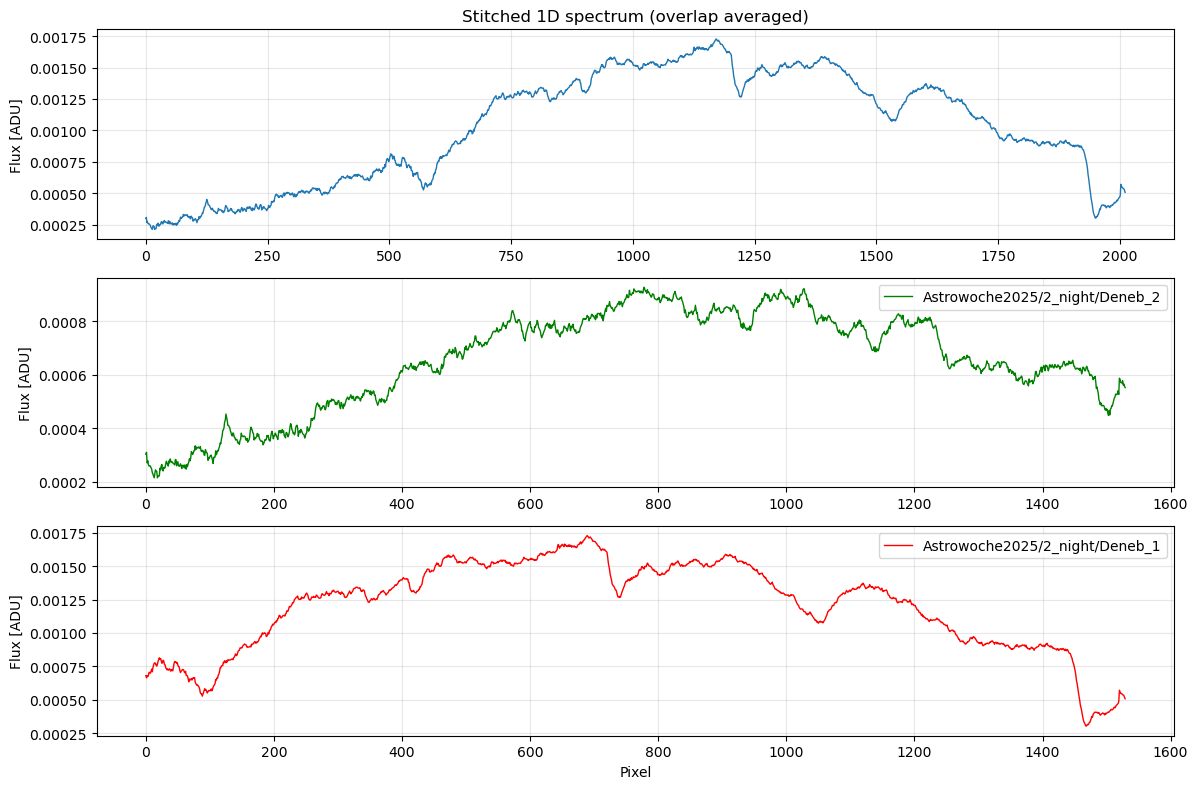

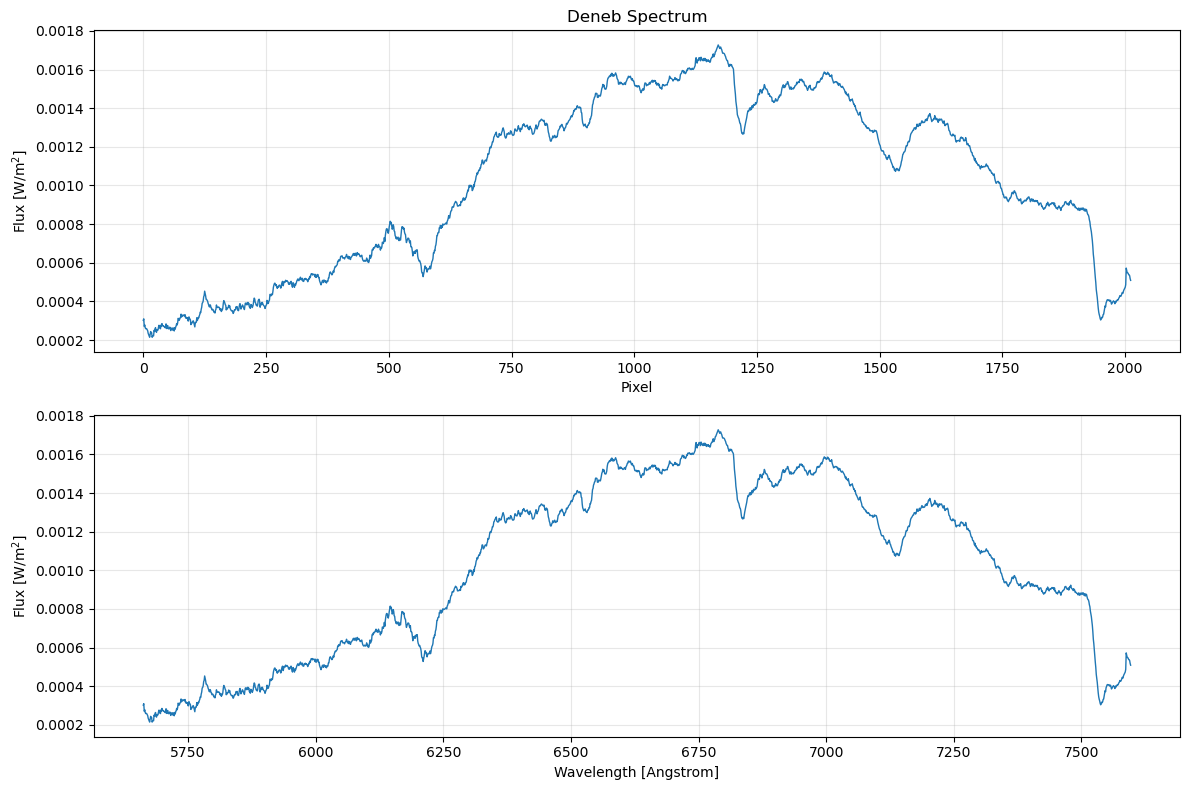

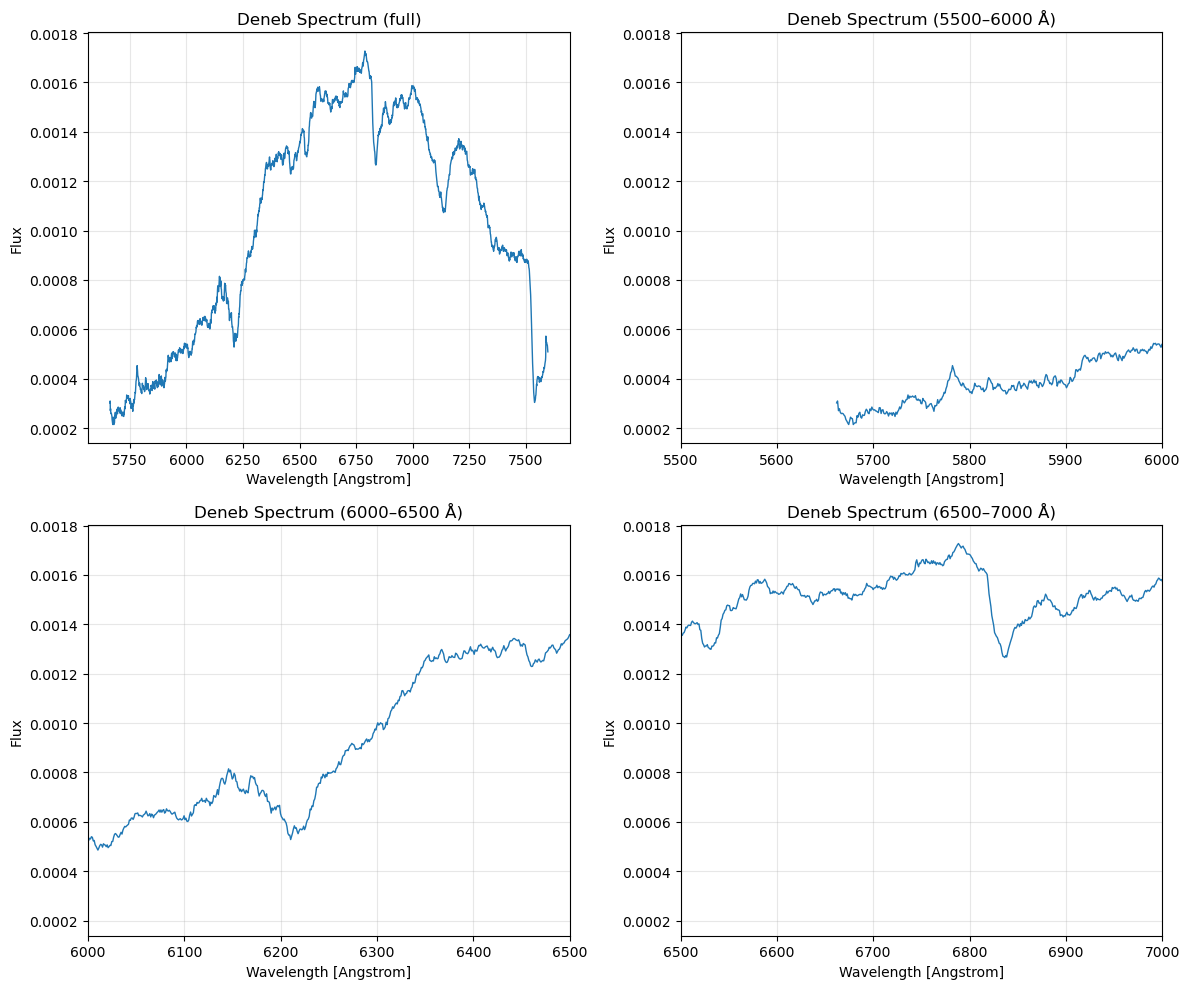

In [236]:
path2 = "Astrowoche2025/2_night/Deneb_1"
path1 = "Astrowoche2025/2_night/Deneb_2"


x_comb_pollux, s_comb_pollux, *rest = combine_spec(path1, path2, folder1 = True, folder2=True, plot = True, scal= 1, shift = shift_2night, filtering = True, delta = 10, normalize = True)
lam_axis_pollux = np.polyval(coeff_2night, x_comb_pollux)
plot_spectrum(x_comb_pollux, lam_axis_pollux, s_comb_pollux, "Deneb Spectrum")



### Merak

Astrowoche2025/2_night/Merak_1\merak_spec_1.FIT
1530
Astrowoche2025/2_night/Merak_1\merak_spec_1_backup.FIT
1530
Astrowoche2025/2_night/Merak_2\merak_spec_2.FIT
1530
Astrowoche2025/2_night/Merak_2\merak_spec_2_backup.FIT
1530
Astrowoche2025/2_night/Merak_2\merak_spec_2_backup_2.FIT
1530
2012


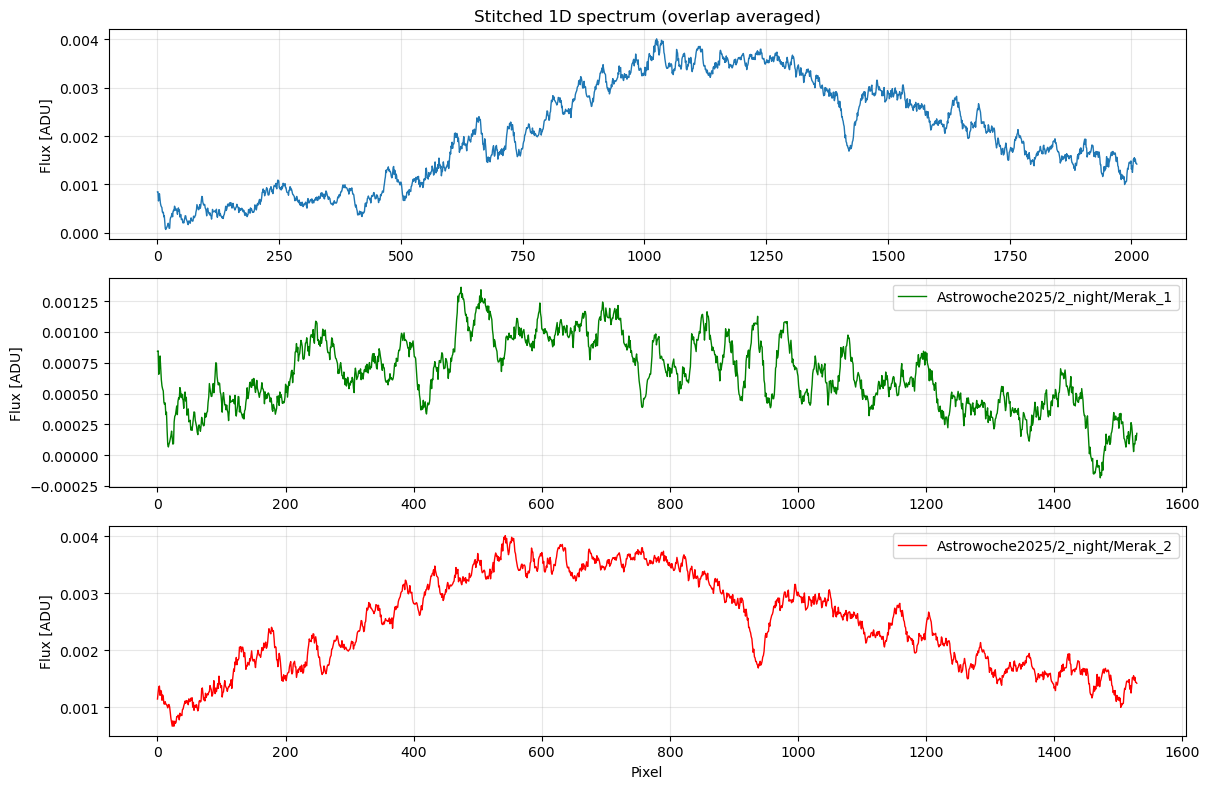

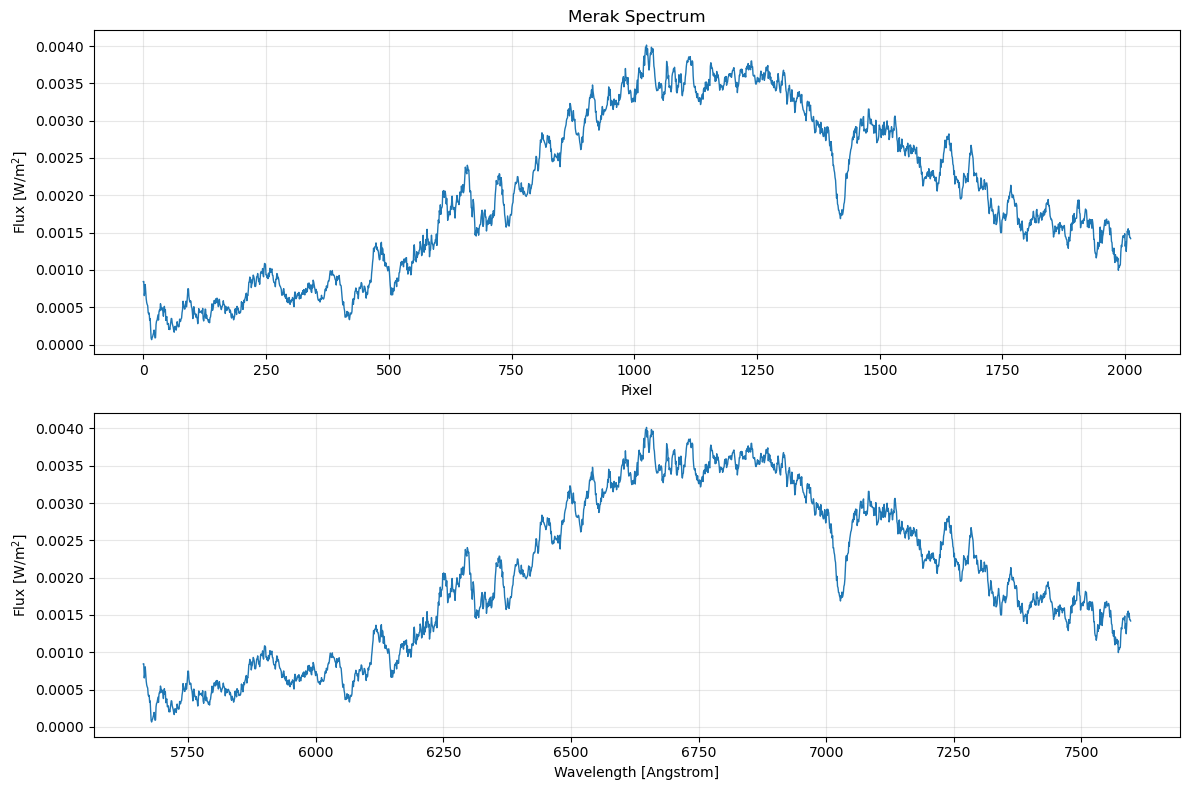

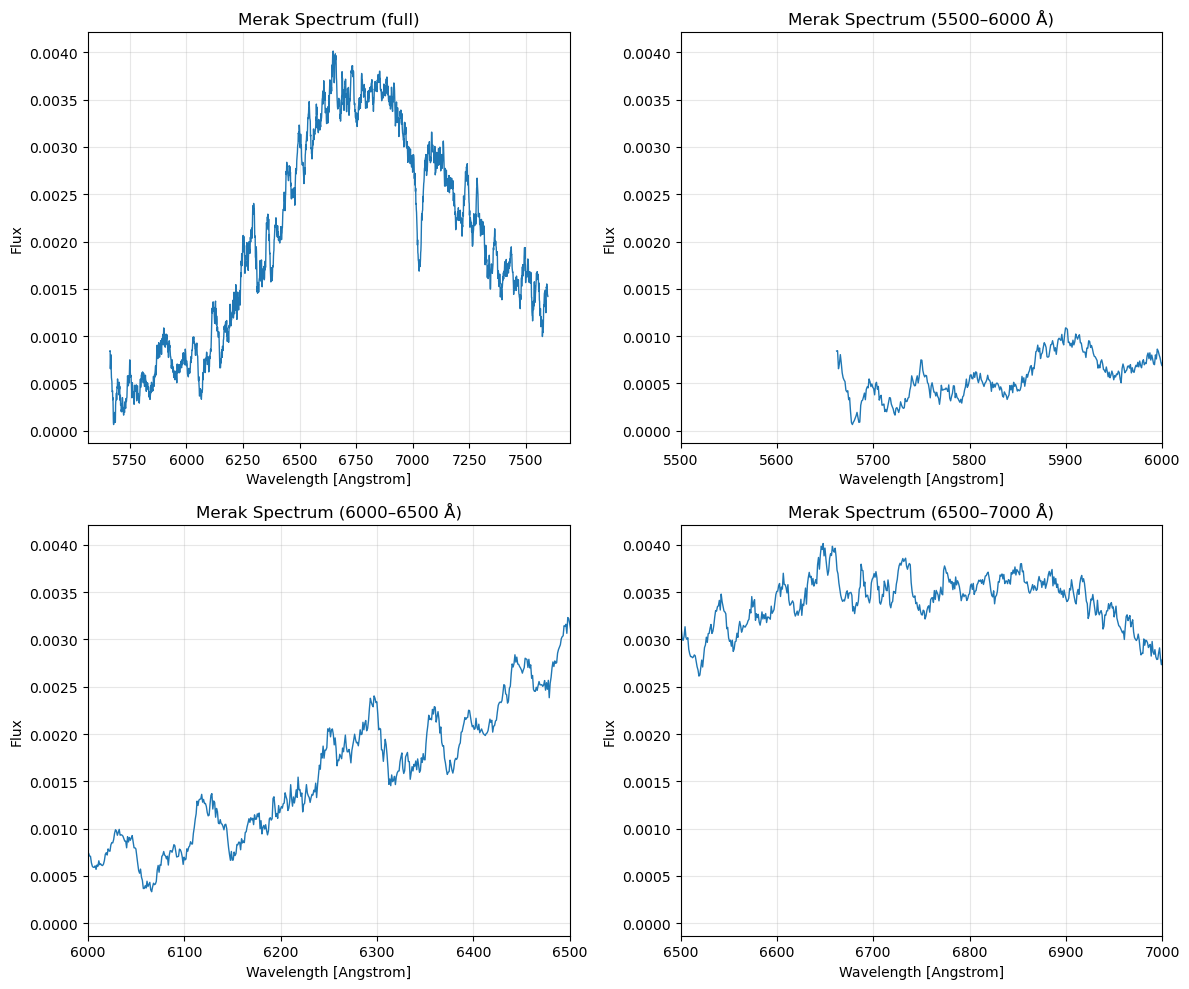

In [232]:
path1 = "Astrowoche2025/2_night/Merak_1"
path2 = "Astrowoche2025/2_night/Merak_2"


x_comb_pollux, s_comb_pollux, *rest = combine_spec(path1, path2, folder1 = True, folder2=True, plot = True, scal= 1, shift = shift_2night, filtering = True, delta = 10, normalize = True)
lam_axis_pollux = np.polyval(coeff_2night, x_comb_pollux)
plot_spectrum(x_comb_pollux, lam_axis_pollux, s_comb_pollux, "Merak Spectrum")



### Polaris

## 3. Night
### 1. Round

shift: 484
2576


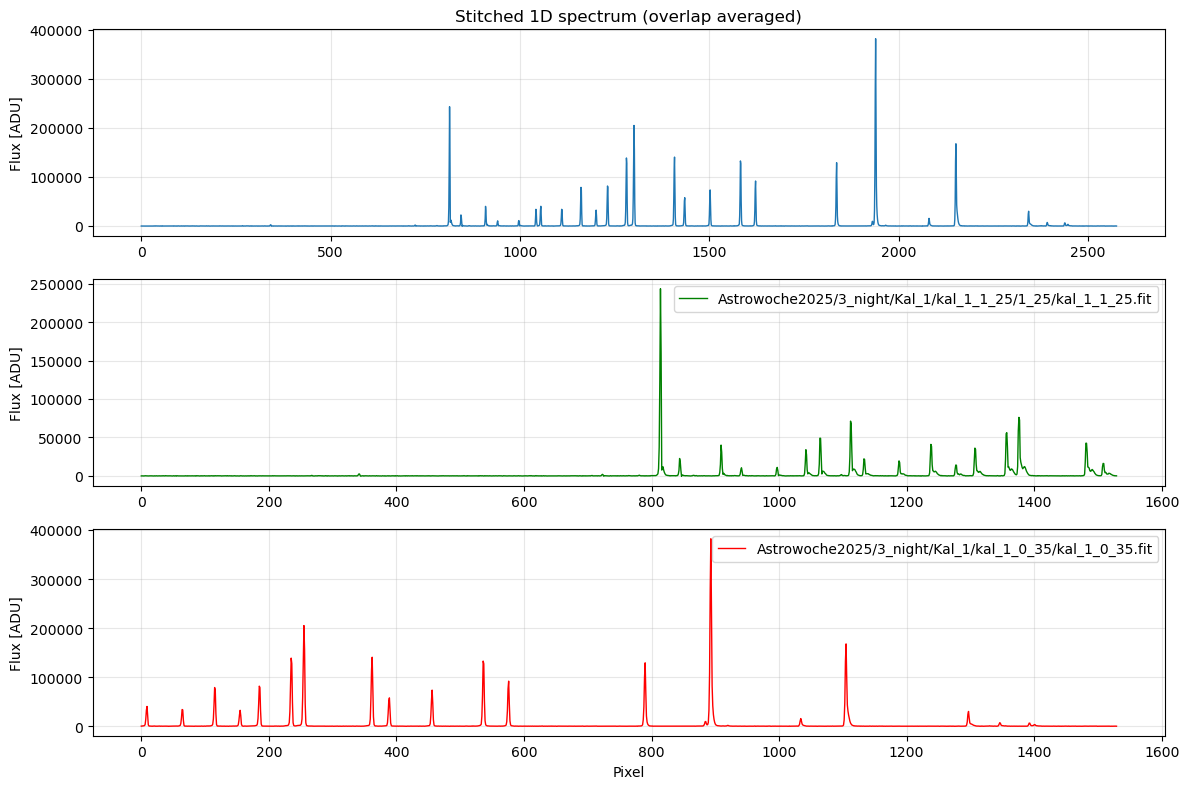

inliers: 8 coeff: [9.76748871e-01 5.05741432e+03]


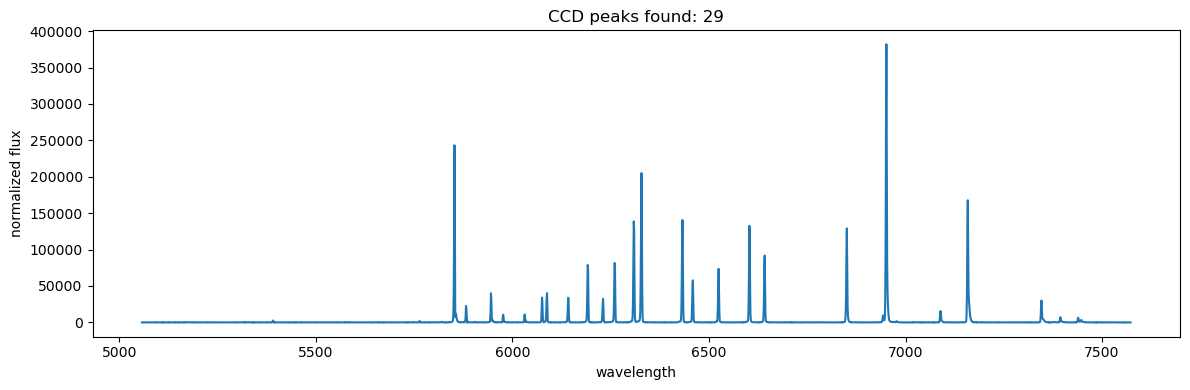

[5852.4879     5856.39489548 5881.79036612 5945.27904271 5949.18603819
 5976.53500657 6031.23294333 6075.18664251 6087.88437782 6141.60556571
 6191.41975811 6230.48971294 6259.79217906 6308.62962259 6328.1646
 6432.67672916 6459.04894867 6524.491123   6602.63103265 6641.70098747
 6850.72524579 6943.5163885  6951.33037947 7089.05197023 7158.40114004
 7345.9369232  7393.79761786 7439.70481478 7447.51880575]


In [203]:

path1 = "Astrowoche2025/3_night/Kal_1/kal_1_1_25/1_25/kal_1_1_25.fit"
path2 = "Astrowoche2025/3_night/Kal_1/kal_1_0_35/kal_1_0_35.fit"

x_comb, s_comb, shift, x1, s1, x2, s2, scal_night3_1 = combine_spec(path1, path2, folder1=False, folder2 = False , plot = True, guess = 400)




ninl, coeff_night3_1 = calibrate_with_anchor(x_comb, s_comb, ref_w, tol=1.5)
print("inliers:", ninl, "coeff:", coeff_night3_1)

lam_axis = np.polyval(coeff_night3_1, x_comb)
peaks, props = find_peaks(s_comb,height = 3000)
plt.figure(figsize=(12,4))
plt.plot(lam_axis ,s_comb,   ms=6)
plt.title(f"CCD peaks found: {len(peaks)}")
plt.xlabel("wavelength")
plt.ylabel("normalized flux")
plt.tight_layout()
plt.show()

print(lam_axis[peaks])

### Vega

Astrowoche2025/3_night/Kal_1/Vega_1\vega_spec_1.FIT
1530
Astrowoche2025/3_night/Kal_1/Vega_1\vega_spec_1_backup.FIT
1530
Astrowoche2025/3_night/Kal_1/Vega_1\vega_spec_1_backup_2.FIT
1530
Astrowoche2025/3_night/Kal_1/Vega_2\vega_spec_2.FIT
1530
Astrowoche2025/3_night/Kal_1/Vega_2\vega_spec_2_backup.FIT
1530
Astrowoche2025/3_night/Kal_1/Vega_2\vega_spec_2_backup_2.FIT
1530
2660


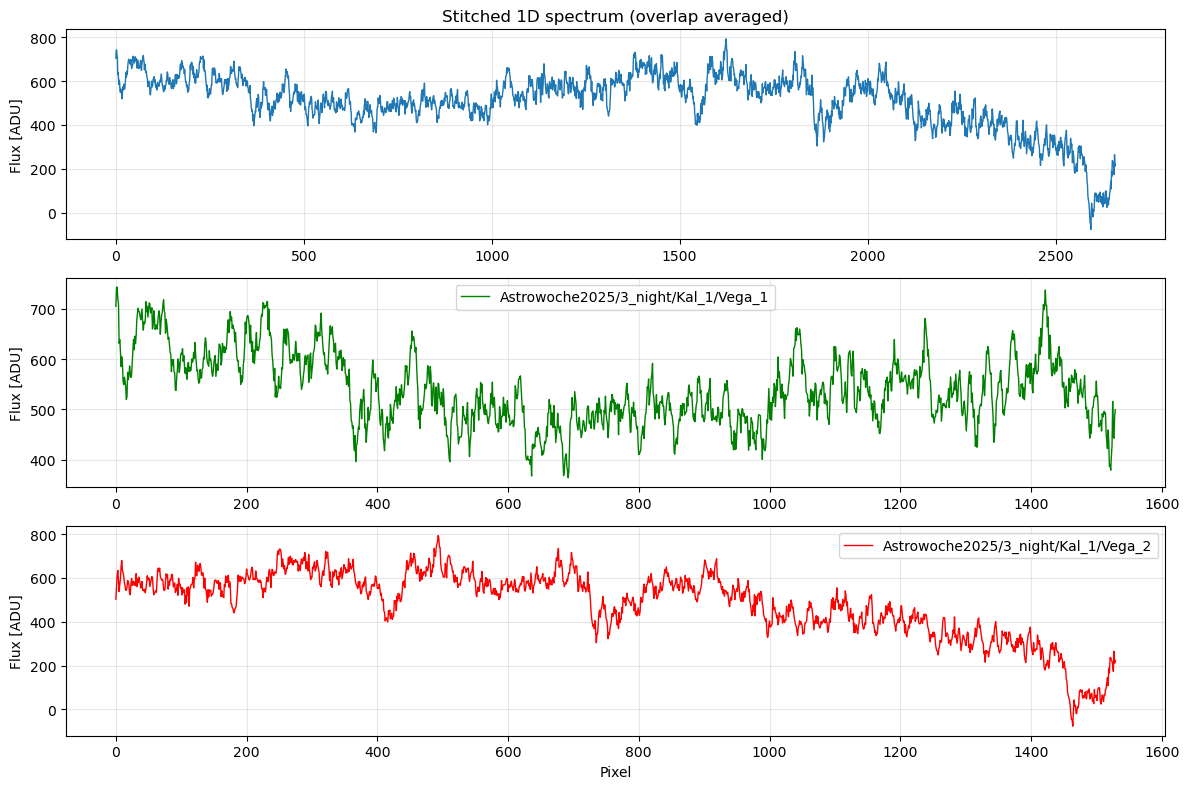

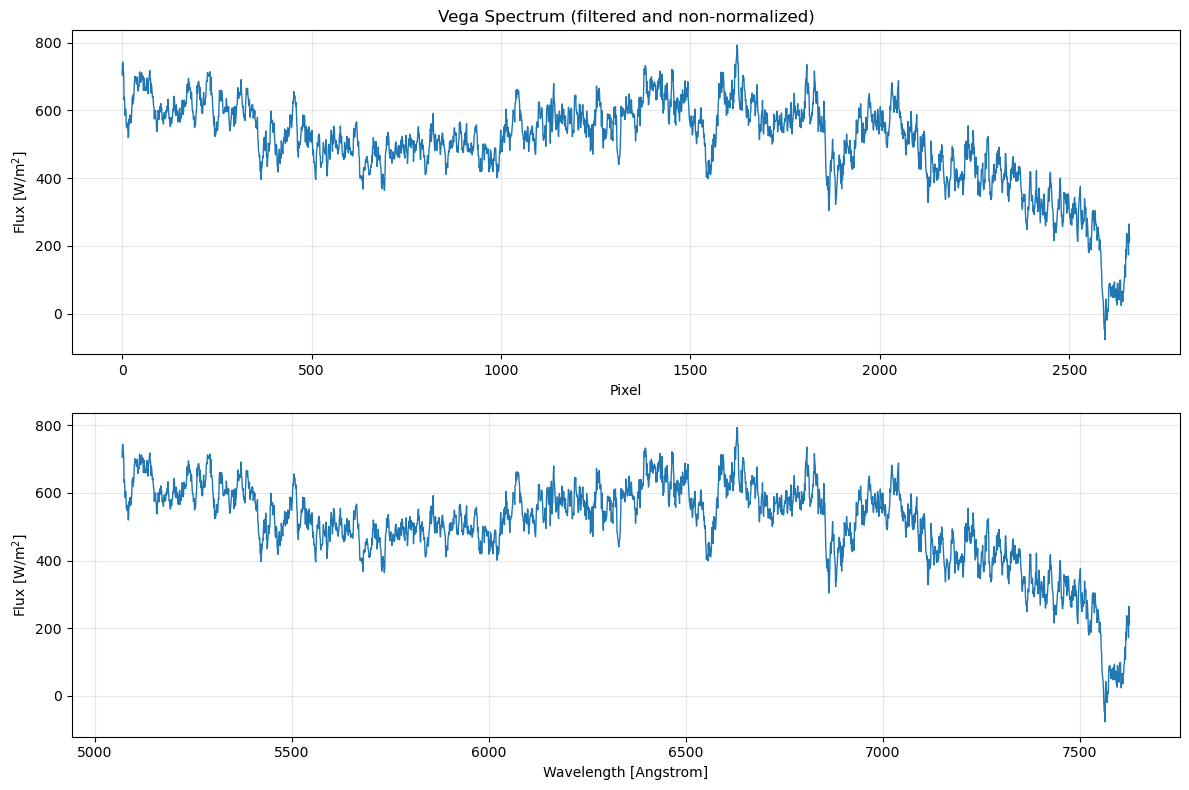

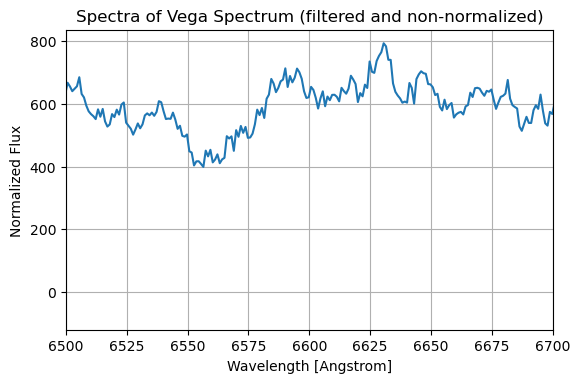

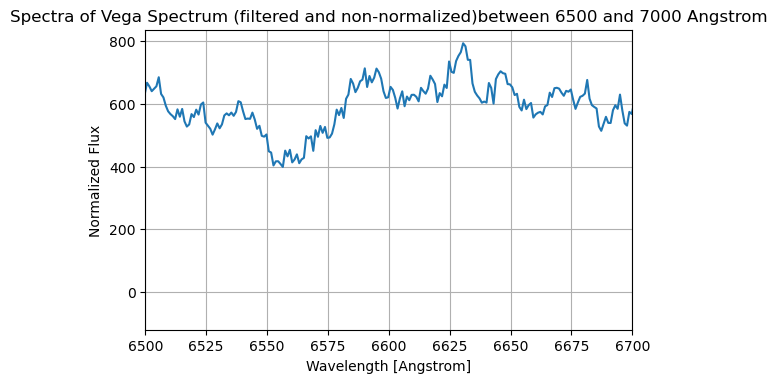

Filename: Astrowoche2025/alpha_lyr_mod_004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      30   ()      
  1  SCI           1 BinTableHDU     23   8094R x 3C   [1D, 1E, 1E]   
['WAVELENGTH', 'FLUX', 'CONTINUUM']


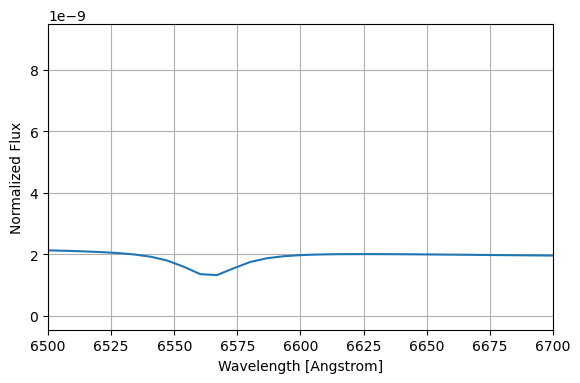

[9.00388727e+02 9.01291391e+02 9.02194936e+02 ... 2.98765844e+06
 2.99065357e+06 2.99365170e+06]


In [35]:
path1 = "Astrowoche2025/3_night/Kal_1/Vega_1"
path2 = "Astrowoche2025/3_night/Kal_1/Vega_2"


x_comb_vega, s_comb_vega, *rest = combine_spec(path1, path2,folder1= True,  folder2 =True,  plot = True, shift = shift_3night_1, scal = 1, filtering = True, normalize = False, delta = 5)
lam_axis_vega = np.polyval(coeff_night3_1, x_comb_vega)
plot_spectrum(x_comb_vega, lam_axis_vega, s_comb_vega, "Vega Spectrum (filtered and non-normalized)")


## Desired Spectrum
from astropy.io import fits

path_vega = "Astrowoche2025/alpha_lyr_mod_004.fits"

fits.info(path_vega)


with fits.open(path_vega) as hdul:
    tab = hdul["SCI"].data          # oder hdul[1].data
    print(tab.names) 

lam_vega  = tab["WAVELENGTH"]   # Beispielname
flux_vega = tab["FLUX"]


cm = 1/2.54
plt.figure(figsize=(15*cm,10*cm))
plt.plot(lam_vega, flux_vega)
plt.xlim(6500, 6700)
plt.xlabel("Wavelength [Angstrom]")
plt.ylabel("Normalized Flux")
plt.tight_layout()
plt.grid()
plt.show()

print(lam_vega)


2660


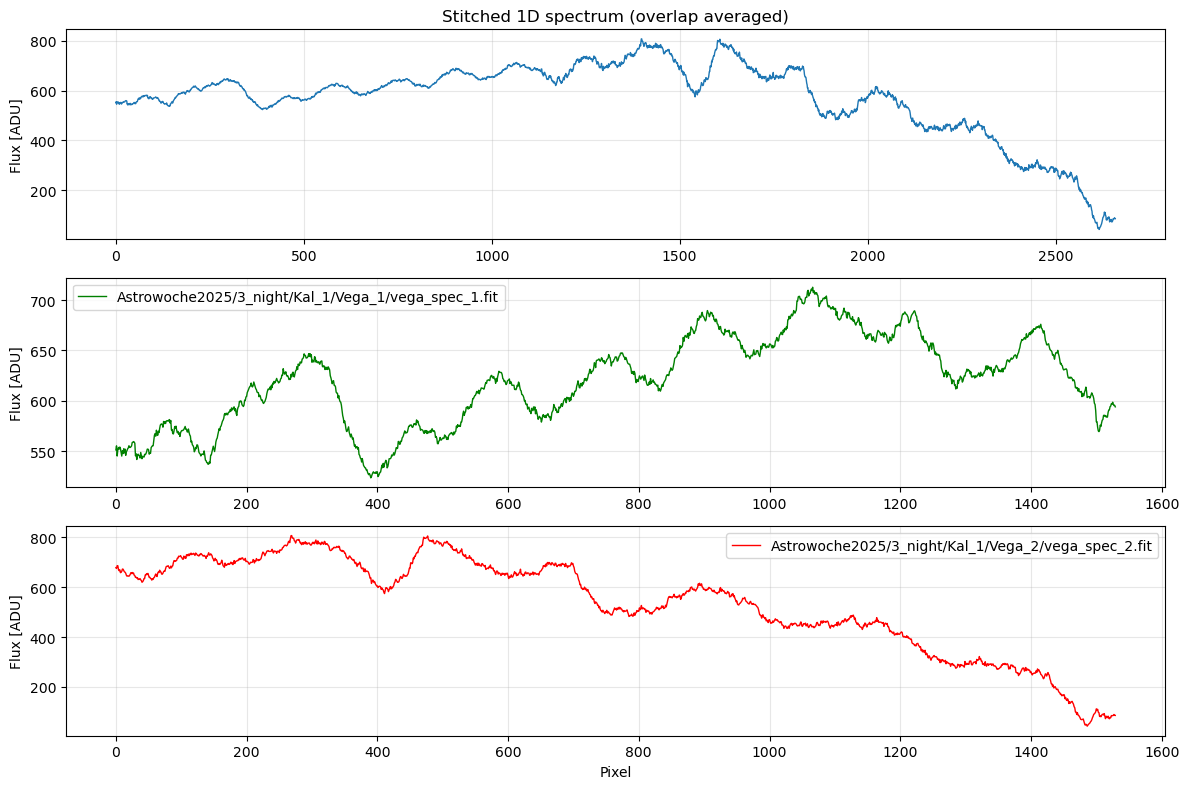

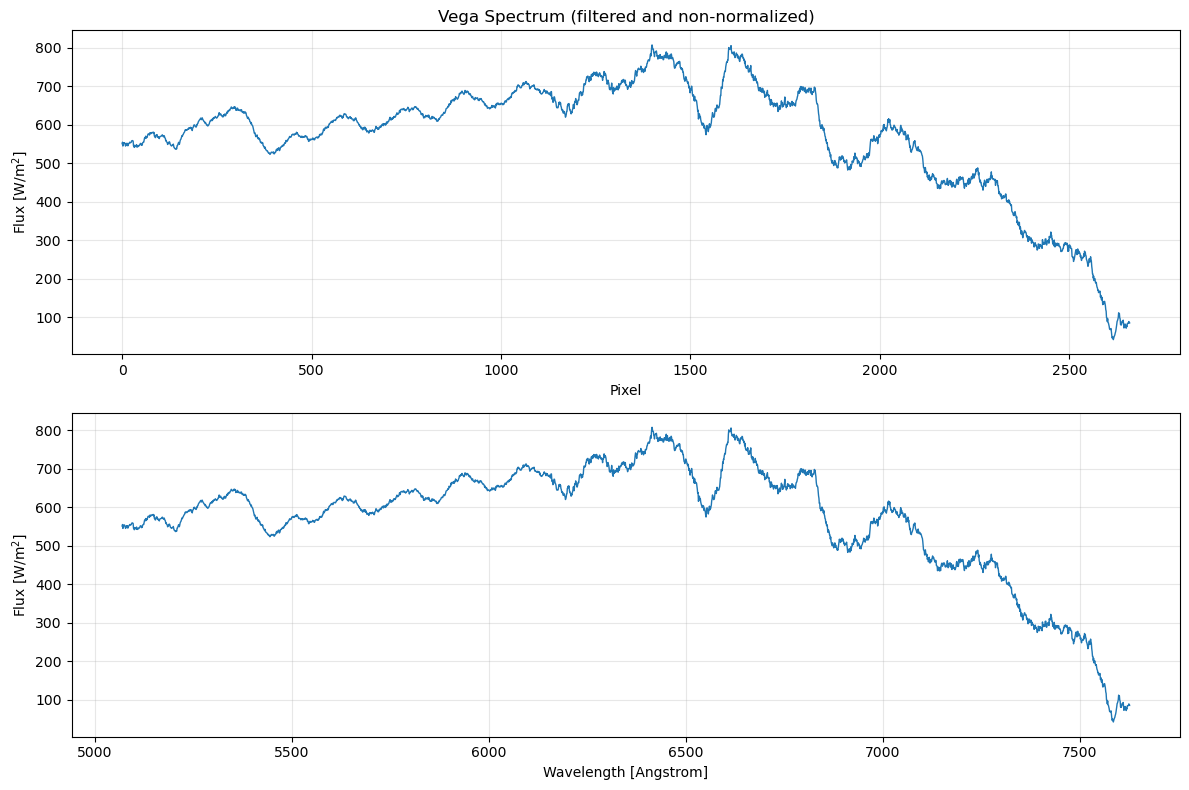

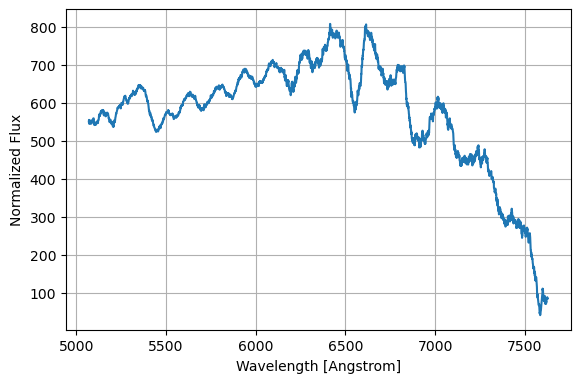

In [90]:
path1 = "Astrowoche2025/3_night/Kal_1/Vega_1/vega_spec_1.fit"
path2 = "Astrowoche2025/3_night/Kal_1/Vega_2/vega_spec_2.fit"


x_comb_vega, s_comb_vega, *rest = combine_spec(path1, path2,folder1= False,  folder2 =False,  plot = True, shift = shift_3night_1, scal = 1, filtering = True, normalize = False, delta = 30)
lam_axis_vega = np.polyval(coeff_night3_1, x_comb_vega)
plot_spectrum(x_comb_vega, lam_axis_vega, s_comb_vega, "Vega Spectrum (filtered and non-normalized)")

## 3. Night Second Round

Astrowoche2025/3_night/Kal_2/kal_2_1_25/1_25\kal_2_1_25.FIT
1530
Astrowoche2025/3_night/Kal_2/kal_2_1_25/1_25\kal_2_1_25_after.FIT
1530
Astrowoche2025/3_night/Kal_2/kal_2_0_35/0_35\kal_2_0_35.FIT
1530
Astrowoche2025/3_night/Kal_2/kal_2_0_35/0_35\kal_2_0_35_after.FIT
1530
shift: 1046
2014


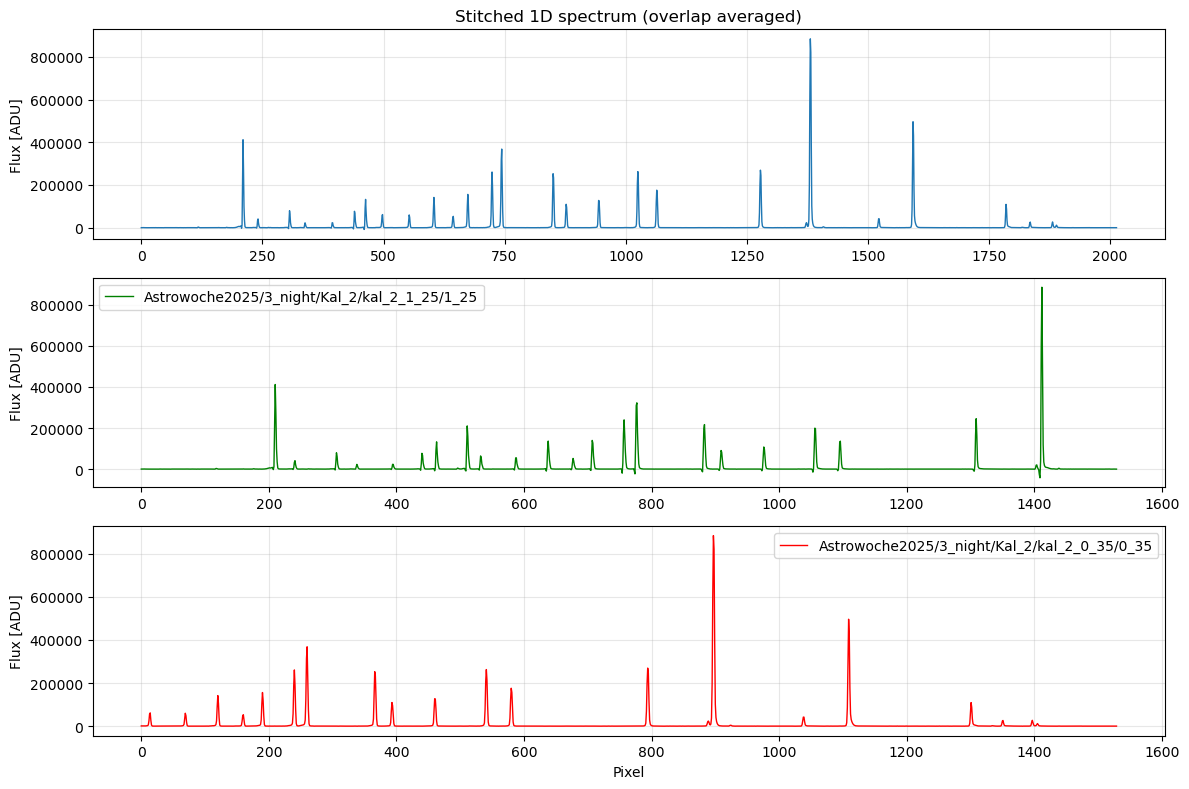

484
Scal: None
inliers: 6 coeff: [6.37544560e-01 5.72434144e+03]


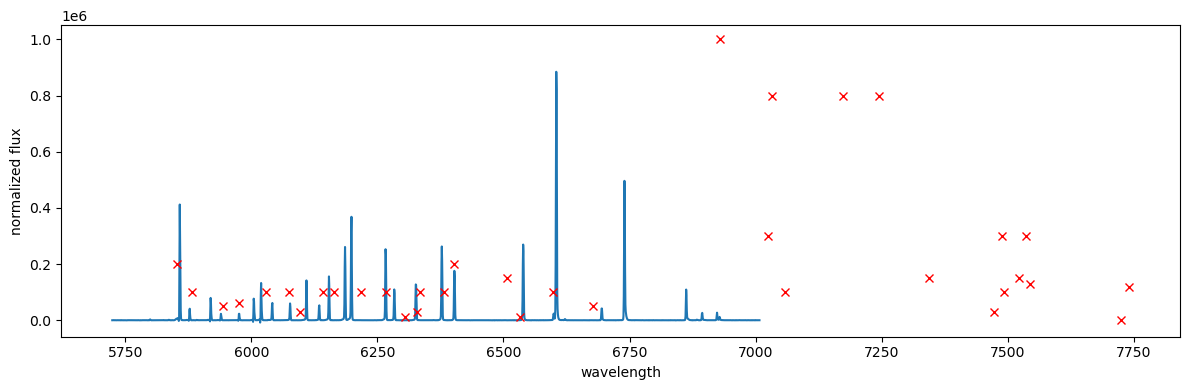

[5852.4879 5881.8952 5944.8342 5975.534  6029.9969 6074.3377 6096.1631
 6143.0626 6163.5939 6217.2812 6266.495  6304.7889 6328.1646 6334.4278
 6382.9917 6402.248  6506.5281 6532.8822 6598.9529 6678.2762 6929.4673
 7024.0504 7032.4131 7059.1074 7173.9381 7245.1666 7343.945  7472.4386
 7488.8712 7492.102  7522.818  7535.7741 7544.0443 7724.6233 7740.738 ]
[5852.4879     5855.6756228  5858.22580104 5877.98968238 5919.43007876
 5939.83150466 5975.534      6004.86104974 6019.52457461 6041.8386342
 6076.90358497 6109.41835751 6134.9201399  6154.04647668 6185.92370466
 6198.67459585 6266.25431917 6283.46802228 6326.18350777 6377.8246171
 6402.68885492 6539.12339067 6599.69012383 6604.79048031 6622.00418342
 6694.68426321 6739.94992694 6862.35848238 6894.23571036 6923.5627601
 6928.66311658]


In [209]:

path1 = "Astrowoche2025/3_night/Kal_2/kal_2_1_25/1_25"
path2 = "Astrowoche2025/3_night/Kal_2/kal_2_0_35/0_35"

# shift_1night_1 = 700
x_comb, s_comb, shift_1night_1, x1, s1, x2, s2, scal = combine_spec(path1, path2, folder1 = True, folder2 = True, plot = True, guess = 1000)
# x_comb, s_comb, shift, x1, s1, x2, s2, scal = combine_spec(path1, path2, plot = True, shift = shift_1night_1)
print(shift)
print("Scal:", scal)

ninl, coeff_1night_1 = calibrate_with_anchor(x_comb, s_comb, ref_w, tol=1.5)
print("inliers:", ninl, "coeff:", coeff_1night_1)

lam_axis = np.polyval(coeff_1night_1, x_comb)
peaks, props = find_peaks(s_comb,height = 3000)
plt.figure(figsize=(12,4))
plt.plot(lam_axis ,s_comb,   ms=6)
plt.plot(ref_w, ref_I*1000, "rx")
plt.xlabel("wavelength")
plt.ylabel("normalized flux")
plt.tight_layout()
plt.show()

print(ref_w)
print(lam_axis[peaks])


## Regulus

Astrowoche2025/3_night/Kal_2/Regulus_1\regulus_spec_1.FIT
1530
Astrowoche2025/3_night/Kal_2/Regulus_1\regulus_spec_1_backup.FIT
1530
Astrowoche2025/3_night/Kal_2/Regulus_1\regulus_spec_1_backup_2.FIT
1530
Astrowoche2025/3_night/Kal_2/Regulus_2\regulus_spec_2.FIT
1530
Astrowoche2025/3_night/Kal_2/Regulus_2\regulus_spec_2_backup.FIT
1530
2039


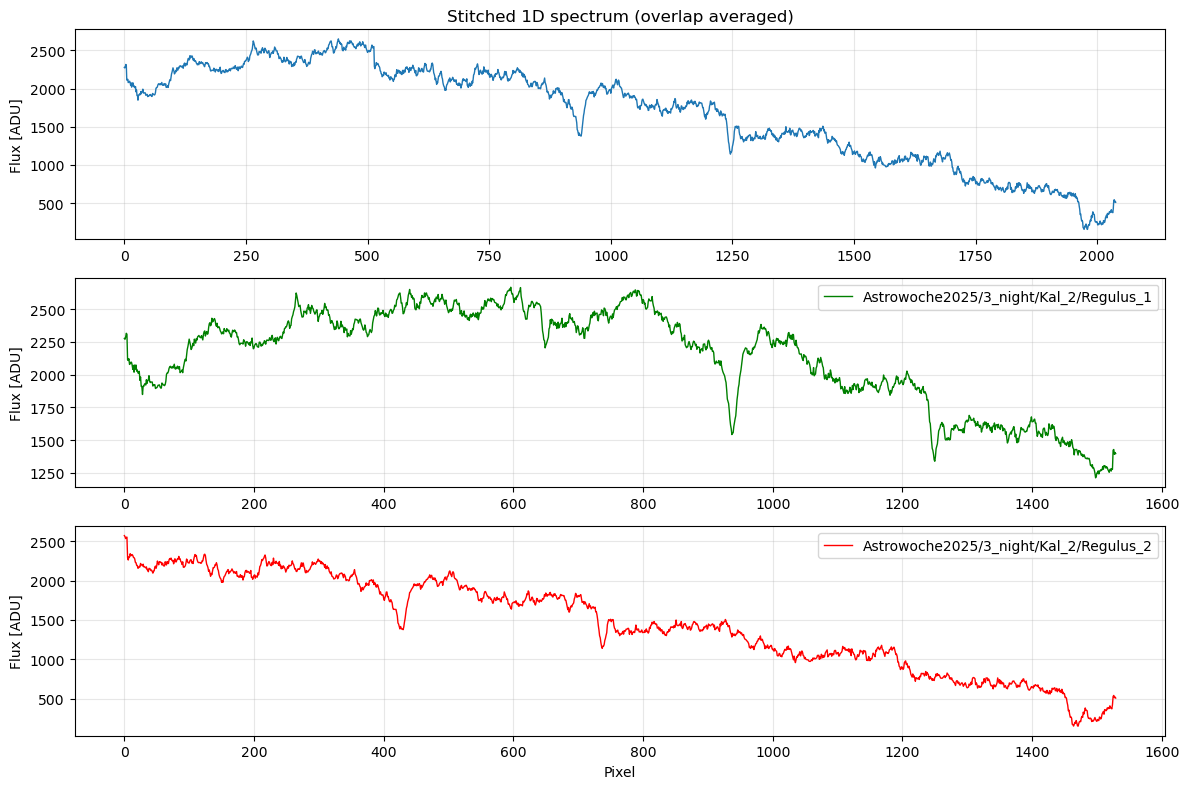

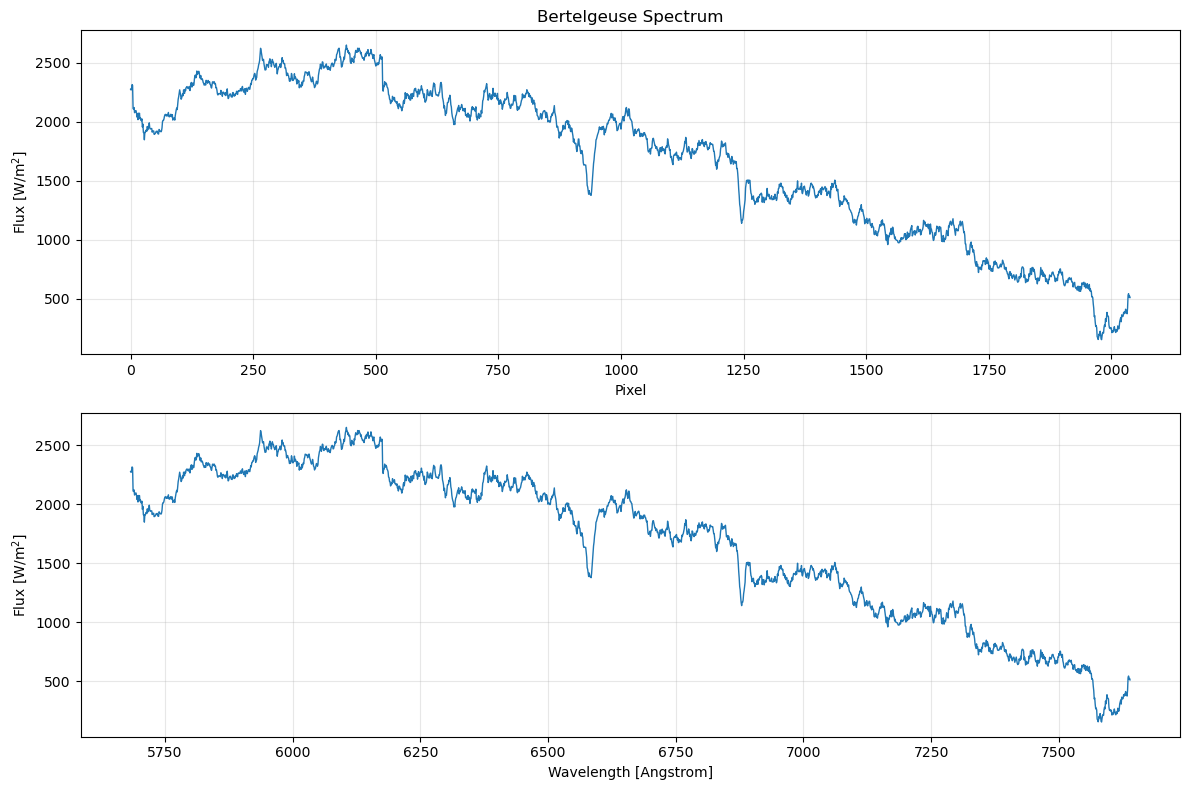

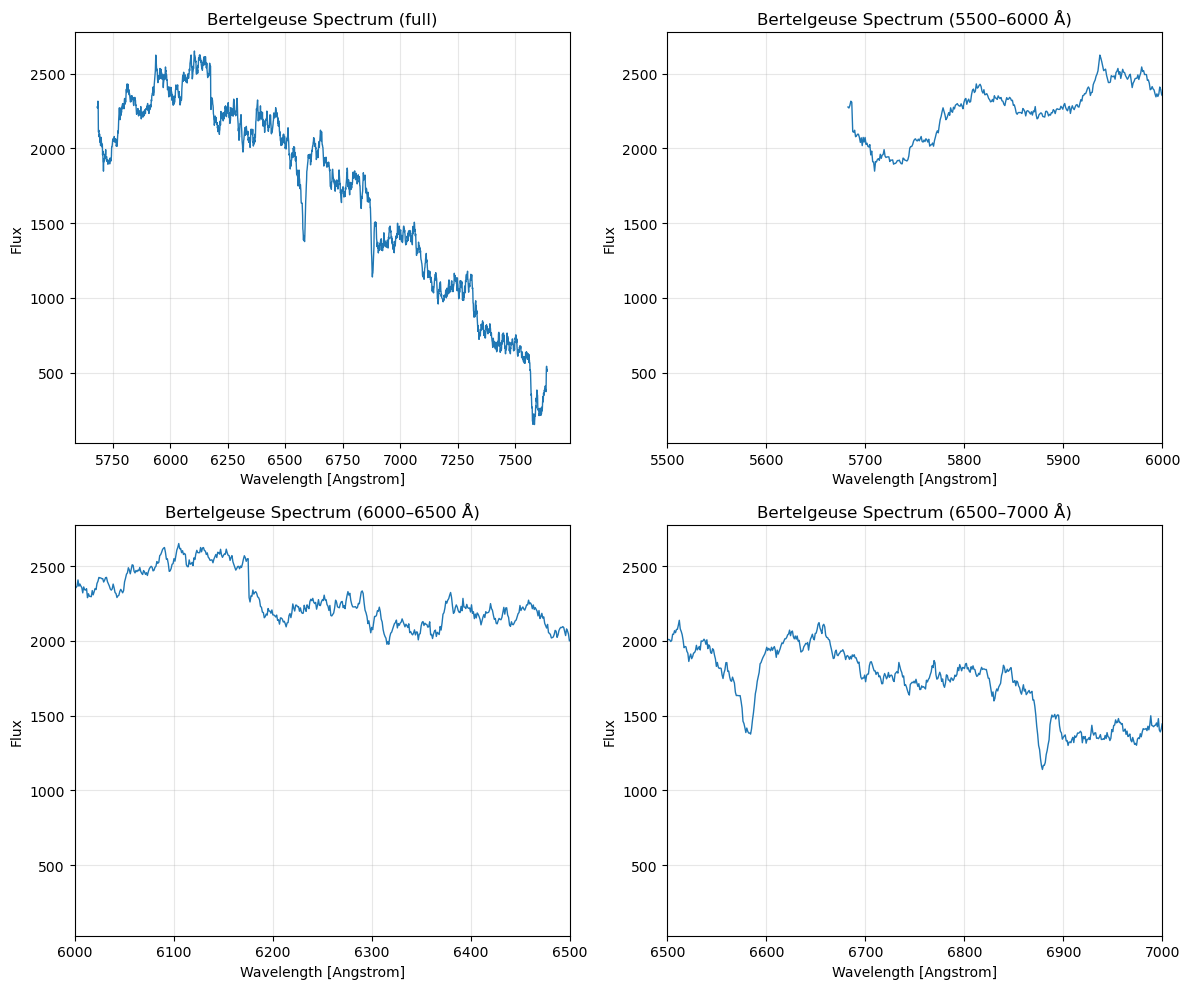

In [210]:
path1 = "Astrowoche2025/3_night/Kal_2/Regulus_1"
path2 = "Astrowoche2025/3_night/Kal_2/Regulus_2"


x_comb_pollux, s_comb_pollux, *rest = combine_spec(path1, path2, folder1 = True, folder2=True, plot = True, scal= 1, shift = shift_1night_2, filtering = True, delta = 5)
lam_axis_pollux = np.polyval(coeff_night1_2, x_comb_pollux)
plot_spectrum(x_comb_pollux, lam_axis_pollux, s_comb_pollux, "Regulus Spectrum")

